# Series analysis


Analysis updates:
- retrieve calls rejected only because VAF<0.01 (bcbio lower acceptable threshold) for Mutect2, Strelka2 and Vardict
- correct for germline mutations using GATK haplotype calls
- get PR curves for sinvict by encoding the 6 files as thresholds. Assumption: linear filters
- plotting: PR curves stops at 10e-2 on the left
- ground truths:

    1) Consensus: build using
        majority of 5/8 callers for SNV and 3/5 callers for INDELS


    2) Ranked mutations: metascore built using
        weigthed sum of normalised scores between 0 and 1 for each caller
        with weigths = inversially proportional to number of calls made by caller (if a caller calls few mutations higher weight, it many calls low weight)
        threshold = 1/ncallers
        interpretation: if 1 caller is sure (score = 1) of calling this position, add it to GT
        interpretation: if 2 callers are quite sure of calling this position (score > 0,5 each), add it to GT
        
- integrate VAF approx

    1) mixture with VAF instead of tumor burden
    
    2) correct for mutations non present in diluted samples (vaf = 0)
    
    3) pool patients together using VAF

In [5]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *
from utils.calltable import *
from utils.calltableseries import *
from utils.groundtruth import *
from utils.metricsseries import *
from utils.venn import venn6, get_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [6]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)
print(config.methods)

paper
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'abemus', 'sinvict']


In [7]:
# Chomosome

mixtureids =  ['CRC-1014_180816-CW-T_CRC-1014_090516-CW-T', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T', 'CRC-123_310715-CW-T_CRC-123_121115-CW-T']
#mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
reload = True
save = True
fixedvars=['coverage', 'ctdna']
filterparam = 'all'

markers = ['o', '^', 'X']
linestyles = ['-', '-', '-']
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

muttypes = ['snv', 'indel']
metrics = ['auprc', 'precision', 'recall']

chrom = 'all'

# Part I: (1) Load/Generate call tables, (2) Generate Ground truths and (3) Compute/Save metrics per patient

In [18]:
dilutionseries

tf       cov
mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-...  56.300000   70.0311
mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-...  26.273333  149.9740
mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-...  18.766667  149.9810
mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-...  11.260000  149.9970
mixture_CRC-123_310715-CW-T_20x_CRC-123_121115-...   7.506667  150.0000
mixture_CRC-123_310715-CW-T_10x_CRC-123_121115-...   3.753333  150.0000
mixture_CRC-123_310715-CW-T_5x_CRC-123_121115-C...   1.876667  150.0000

############# CRC-123_310715-CW-T_CRC-123_121115-CW-T ############
mixture ['data', 'mixtures']
['3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '22']
mixture ['data', 'mixtures']
mixture_chr3_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x
True reload
hello
mixture_chr3_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x
freebayes
mutect2
retrieving mutect2 1 calls with MinAF tags out of 9
strelka2
retrieving strelka2 0 calls with MinAF tags out of 19
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 376
varscan
abemus
sinvict
# calls before using germline calls from GATK Haplotype: 3337 SNV, 238 INDEL, 2180 SNP
# calls after using germline calls from GATK Haplotype: 2577 SNV, 181 INDEL, 2997 SNP
final shape SNV: (2577, 40)
final shape INDEL: (181, 40)
final shape SNP: (2997, 40)
26.273333333333333
mixture_chr3_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x
True reload
hello
mixture_chr3_CRC-123_310715-CW-T_50x_CRC-123_1211

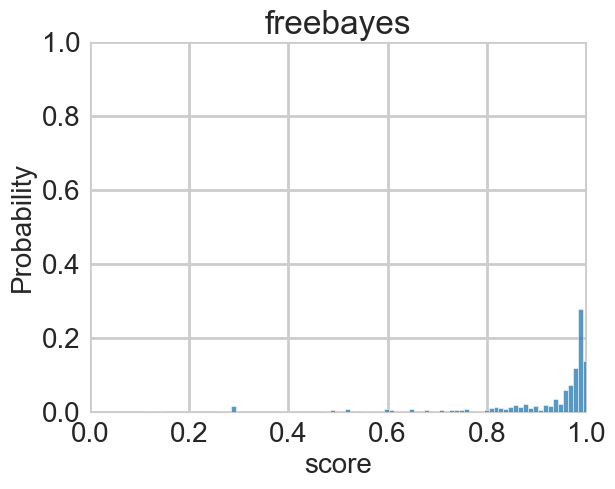

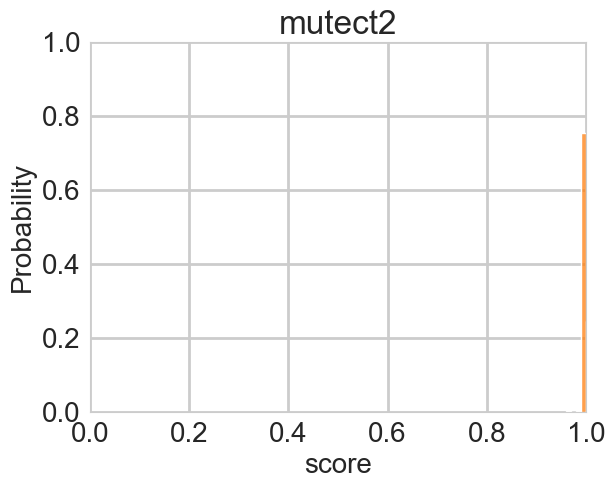

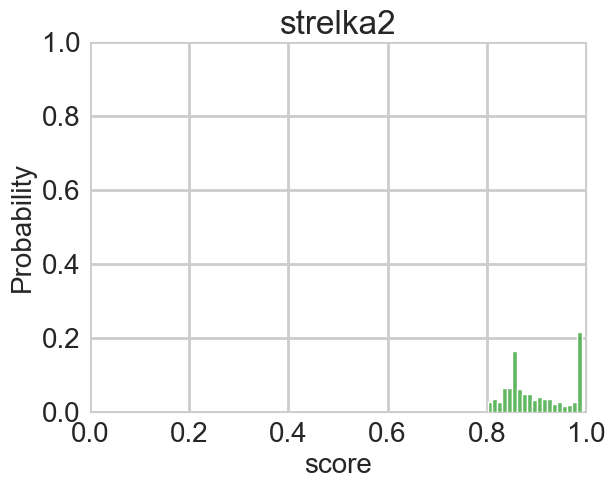

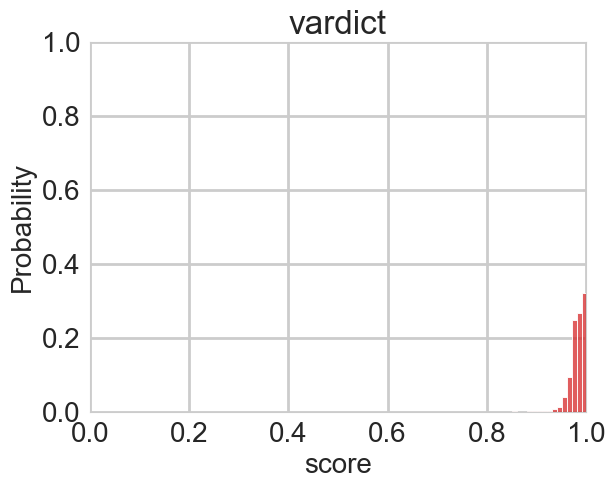

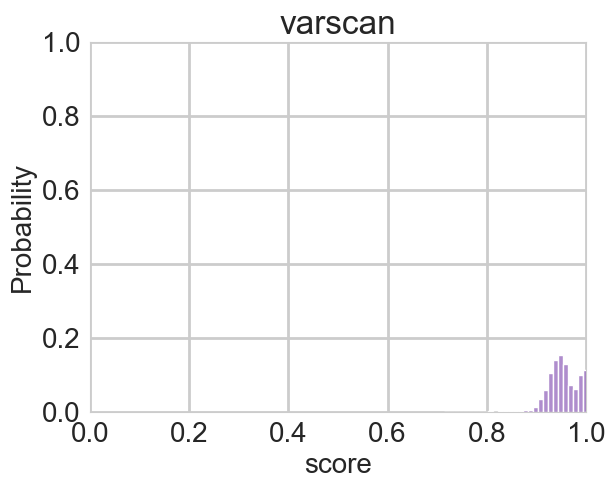

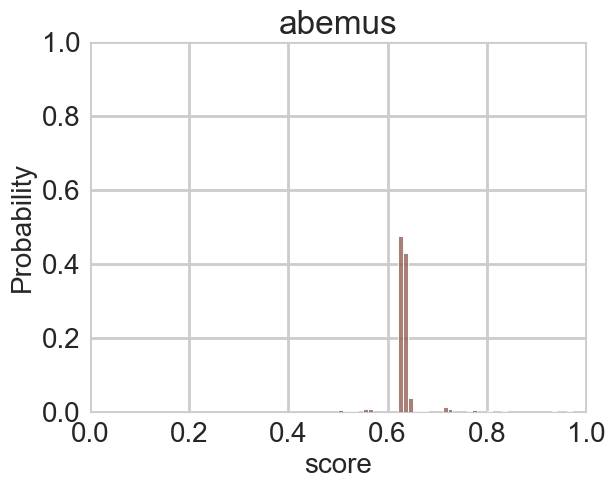

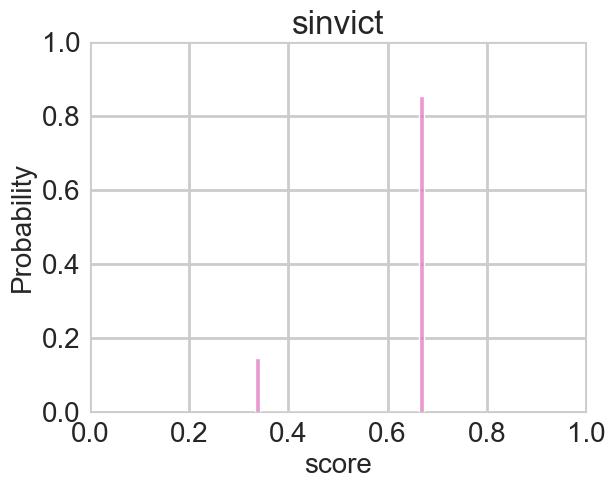

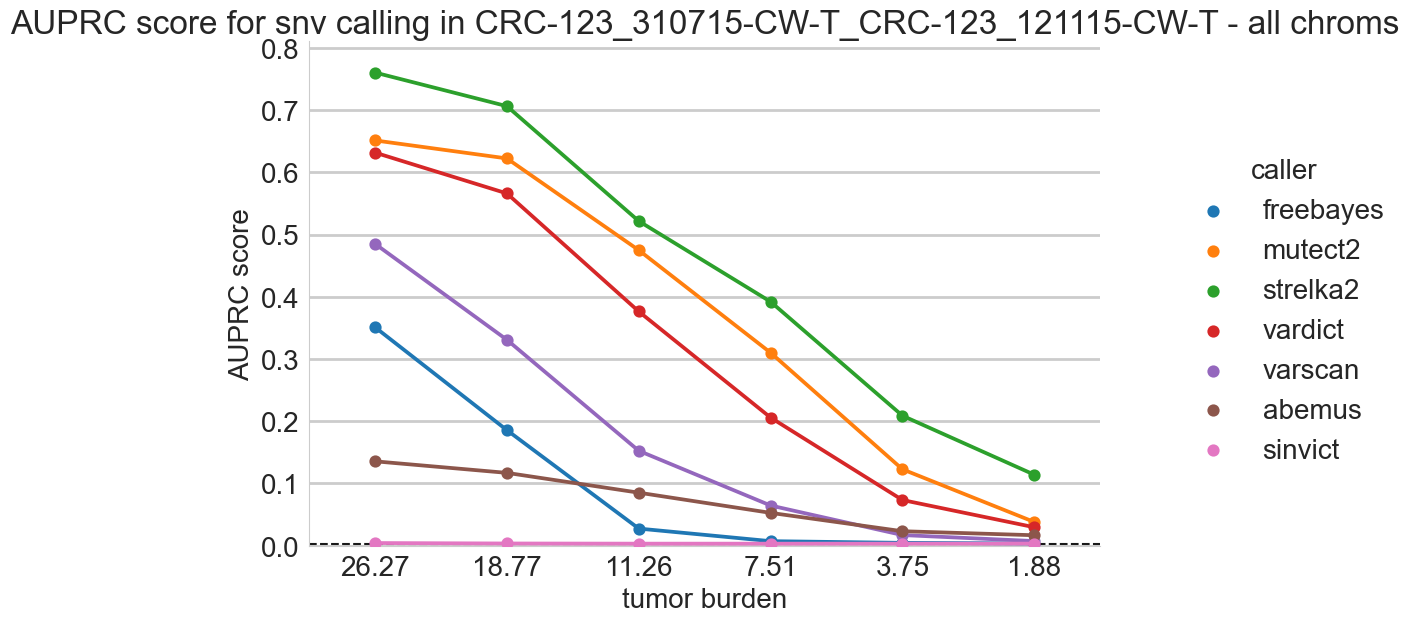

mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x
56.30_freebayes_score
is present
56.30_mutect2_score
is present
56.30_strelka2_score
is present
56.30_vardict_score
is present
56.30_varscan_score
is present
56.30_abemus_score
is present
56.30_sinvict_score
is present
mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x
26.27_freebayes_score
is present
26.27_mutect2_score
is present
26.27_strelka2_score
is present
26.27_vardict_score
is present
26.27_varscan_score
is present
26.27_abemus_score
is present
26.27_sinvict_score
is present
mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x
18.77_freebayes_score
is present
18.77_mutect2_score
is present
18.77_strelka2_score
is present
18.77_vardict_score
is present
18.77_varscan_score
is present
18.77_abemus_score
is present
18.77_sinvict_score
is present
mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x
11.26_freebayes_score
is present
11.26_mutect2_score
is present
11.26_strelka2_score
is present
11.26_vardict_score
is

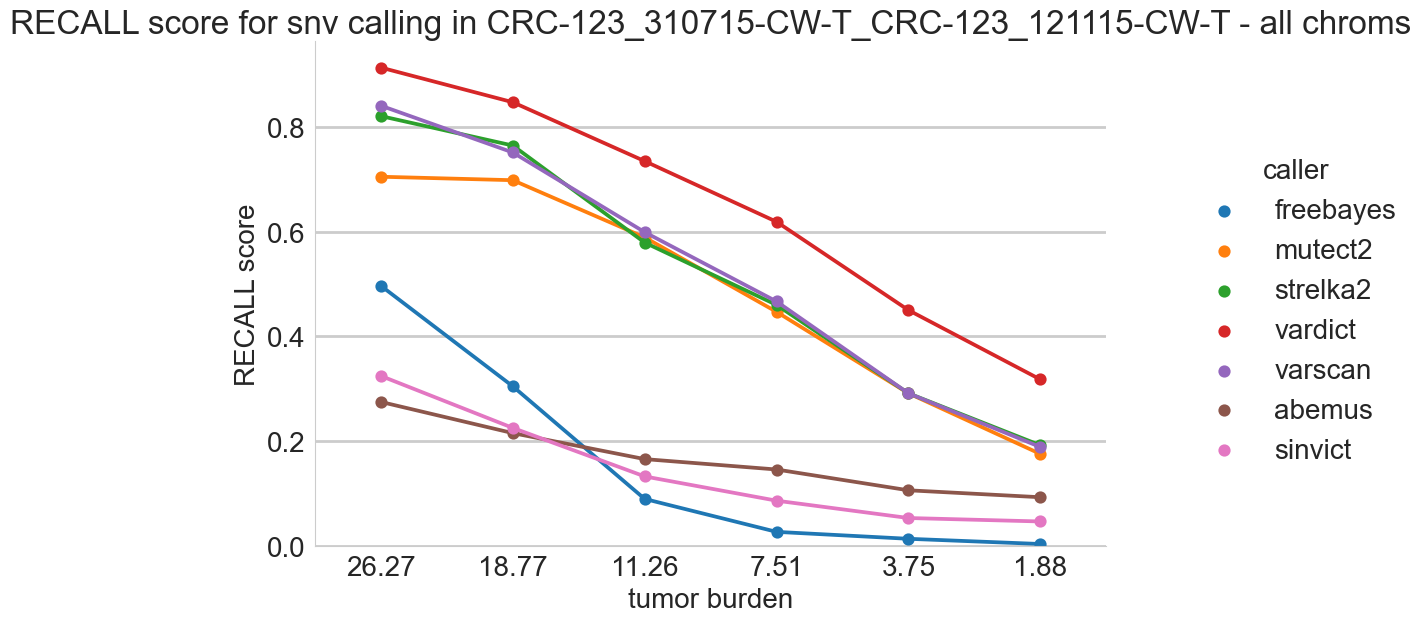

mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x
56.30_freebayes_score
is present
56.30_mutect2_score
is present
56.30_strelka2_score
is present
56.30_vardict_score
is present
56.30_varscan_score
is present
56.30_abemus_score
is present
56.30_sinvict_score
is present
mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x
26.27_freebayes_score
is present
26.27_mutect2_score
is present
26.27_strelka2_score
is present
26.27_vardict_score
is present
26.27_varscan_score
is present
26.27_abemus_score
is present
26.27_sinvict_score
is present
mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x
18.77_freebayes_score
is present
18.77_mutect2_score
is present
18.77_strelka2_score
is present
18.77_vardict_score
is present
18.77_varscan_score
is present
18.77_abemus_score
is present
18.77_sinvict_score
is present
mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x
11.26_freebayes_score
is present
11.26_mutect2_score
is present
11.26_strelka2_score
is present
11.26_vardict_score
is

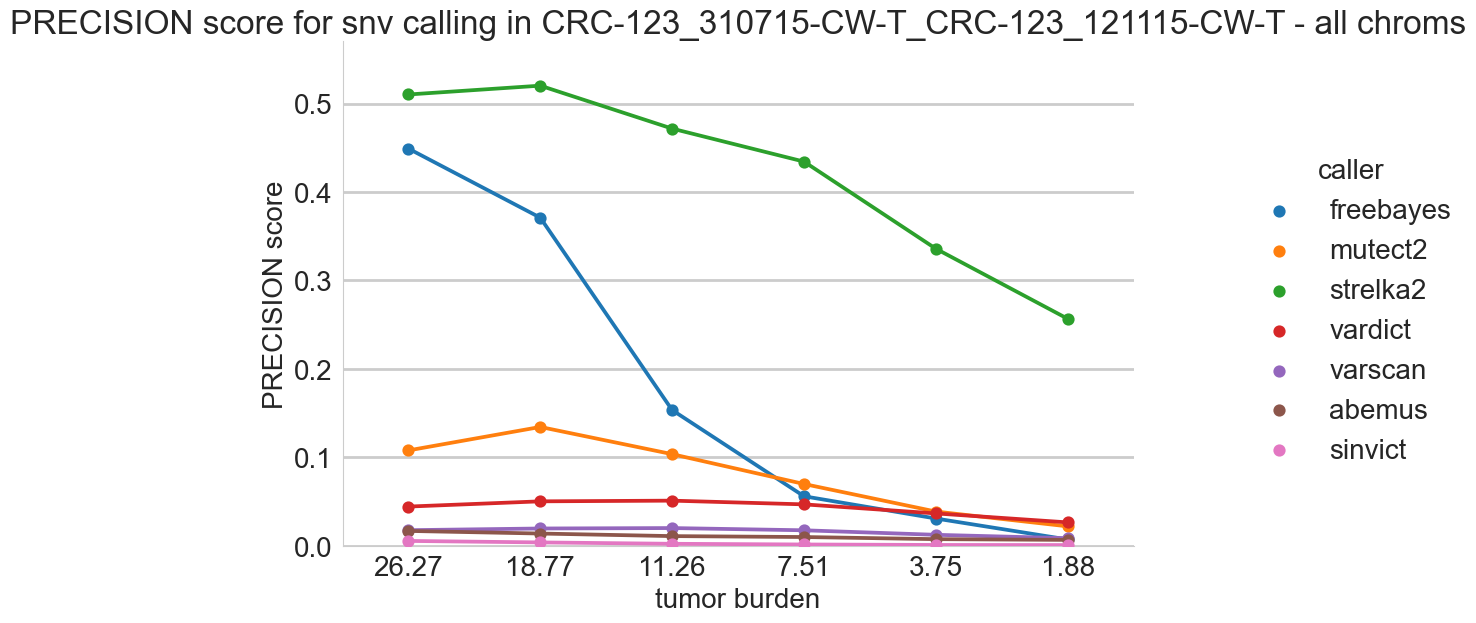

['mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x', 'mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x', 'mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x', 'mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x', 'mixture_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x', 'mixture_CRC-123_310715-CW-T_10x_CRC-123_121115-CW-T_140x', 'mixture_CRC-123_310715-CW-T_5x_CRC-123_121115-CW-T_145x']
56.30_freebayes_score
26.27_freebayes_score
18.77_freebayes_score
11.26_freebayes_score
7.51_freebayes_score
3.75_freebayes_score
1.88_freebayes_score
['mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x', 'mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x', 'mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x', 'mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x', 'mixture_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x', 'mixture_CRC-123_310715-CW-T_10x_CRC-123_121115-CW-T_140x', 'mixture_CRC-123_310715-CW-T_5x_CRC-123_121115-CW-T_145x']
56.30_mutect2_s

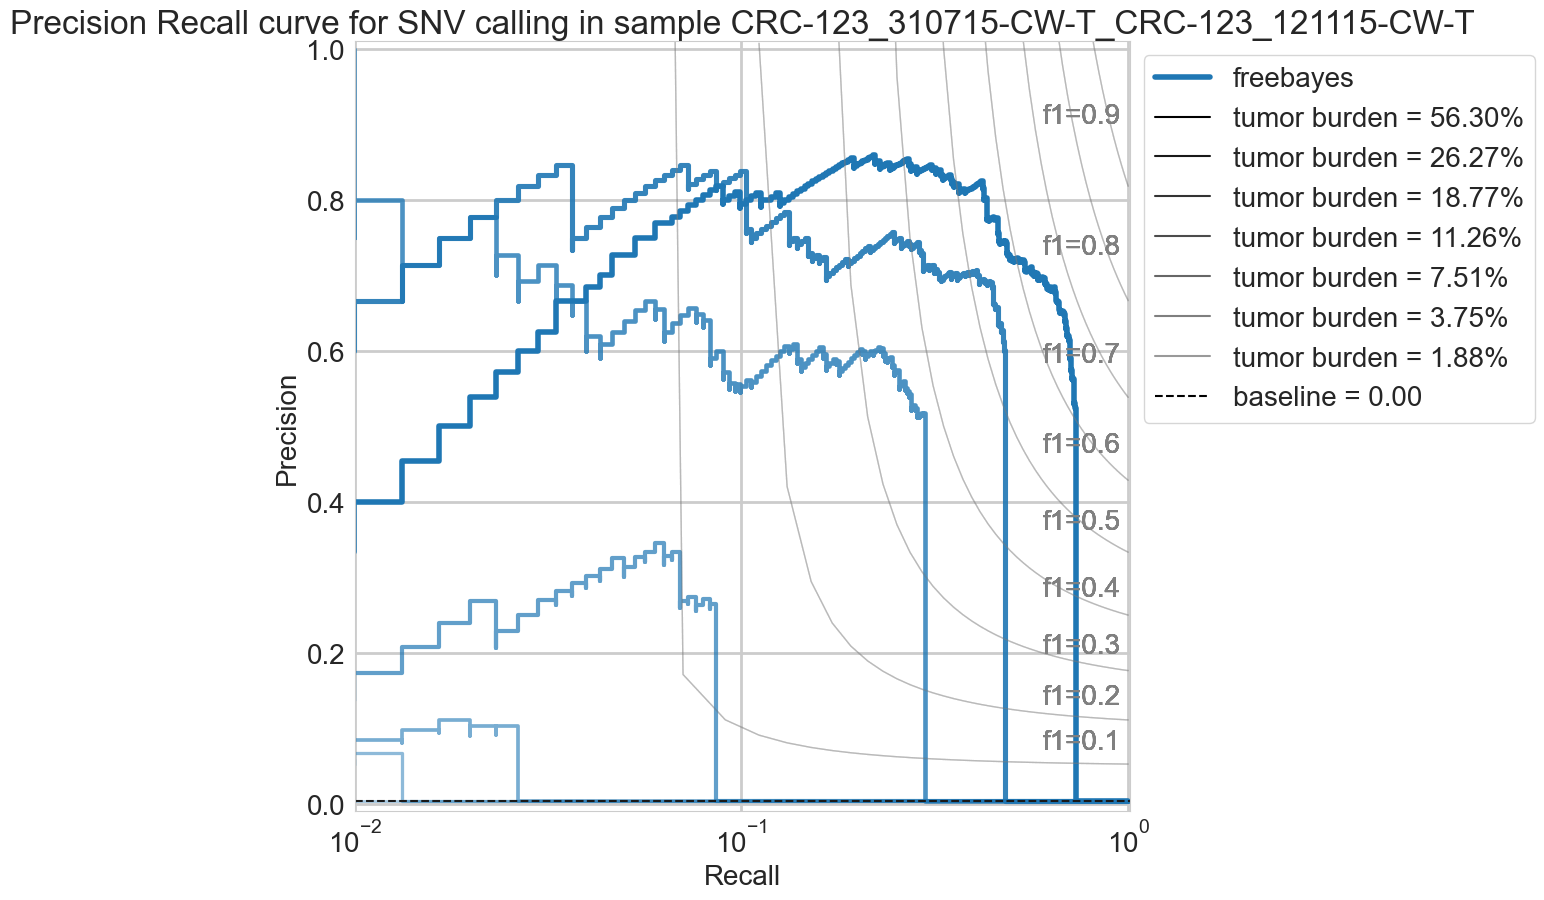

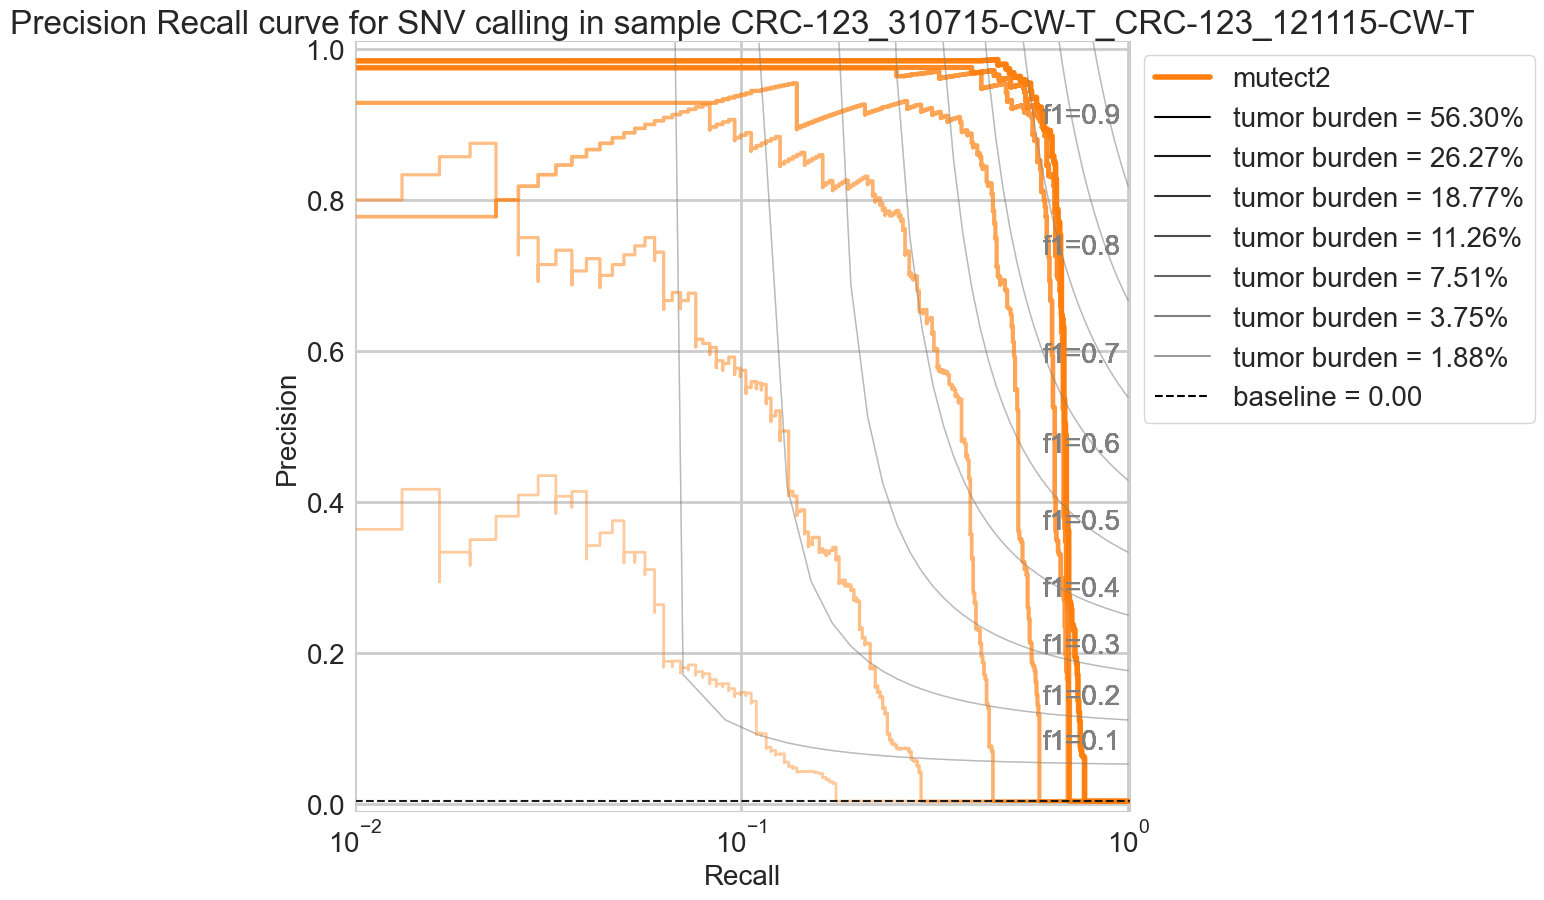

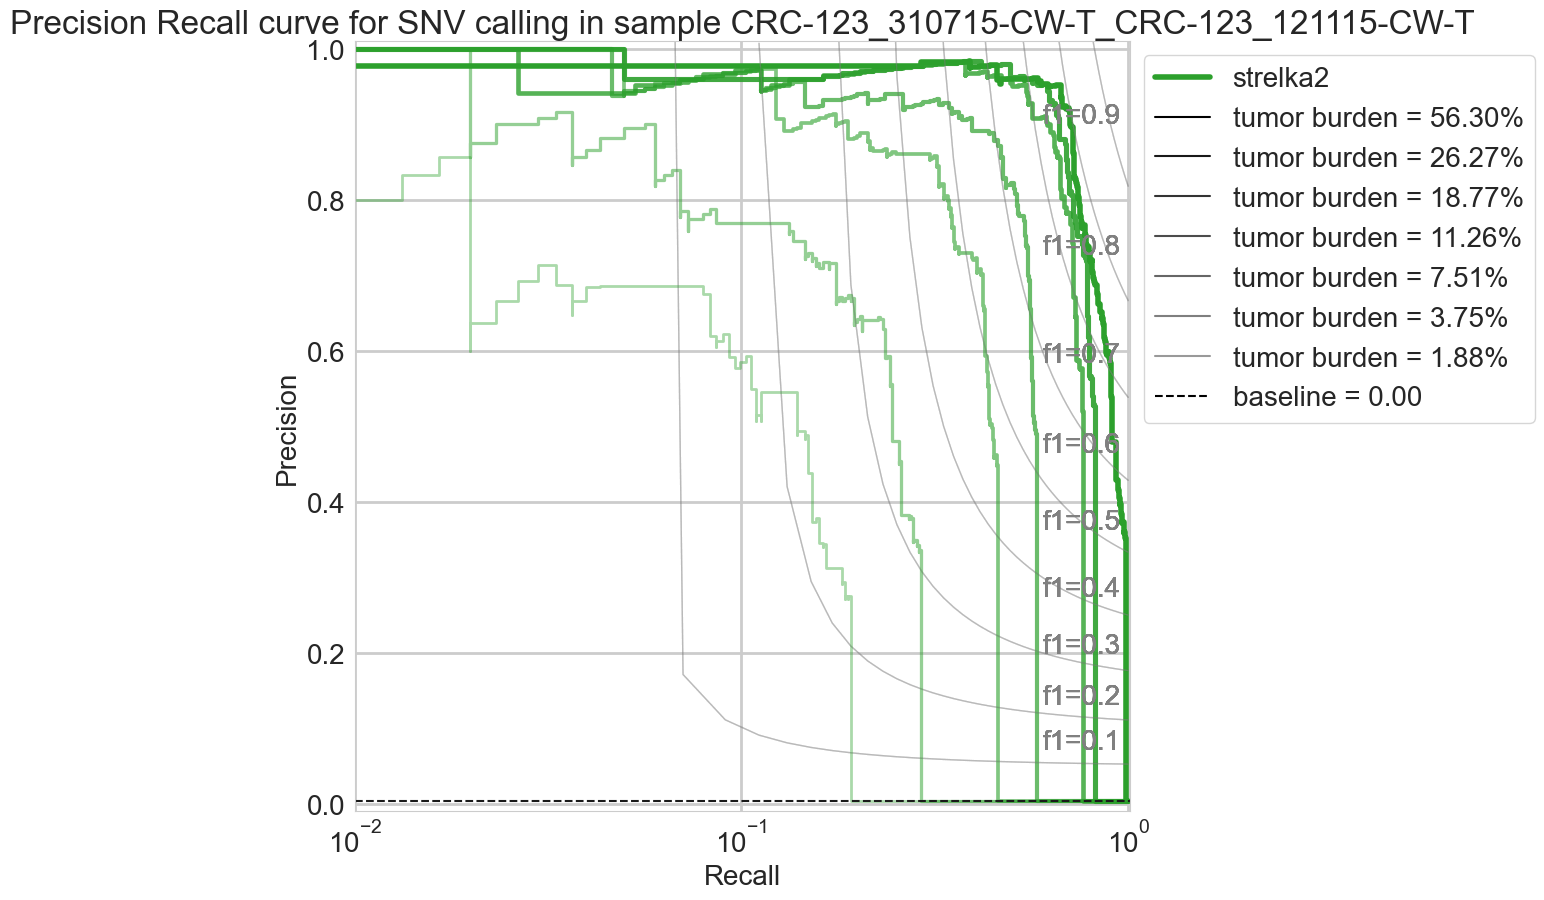

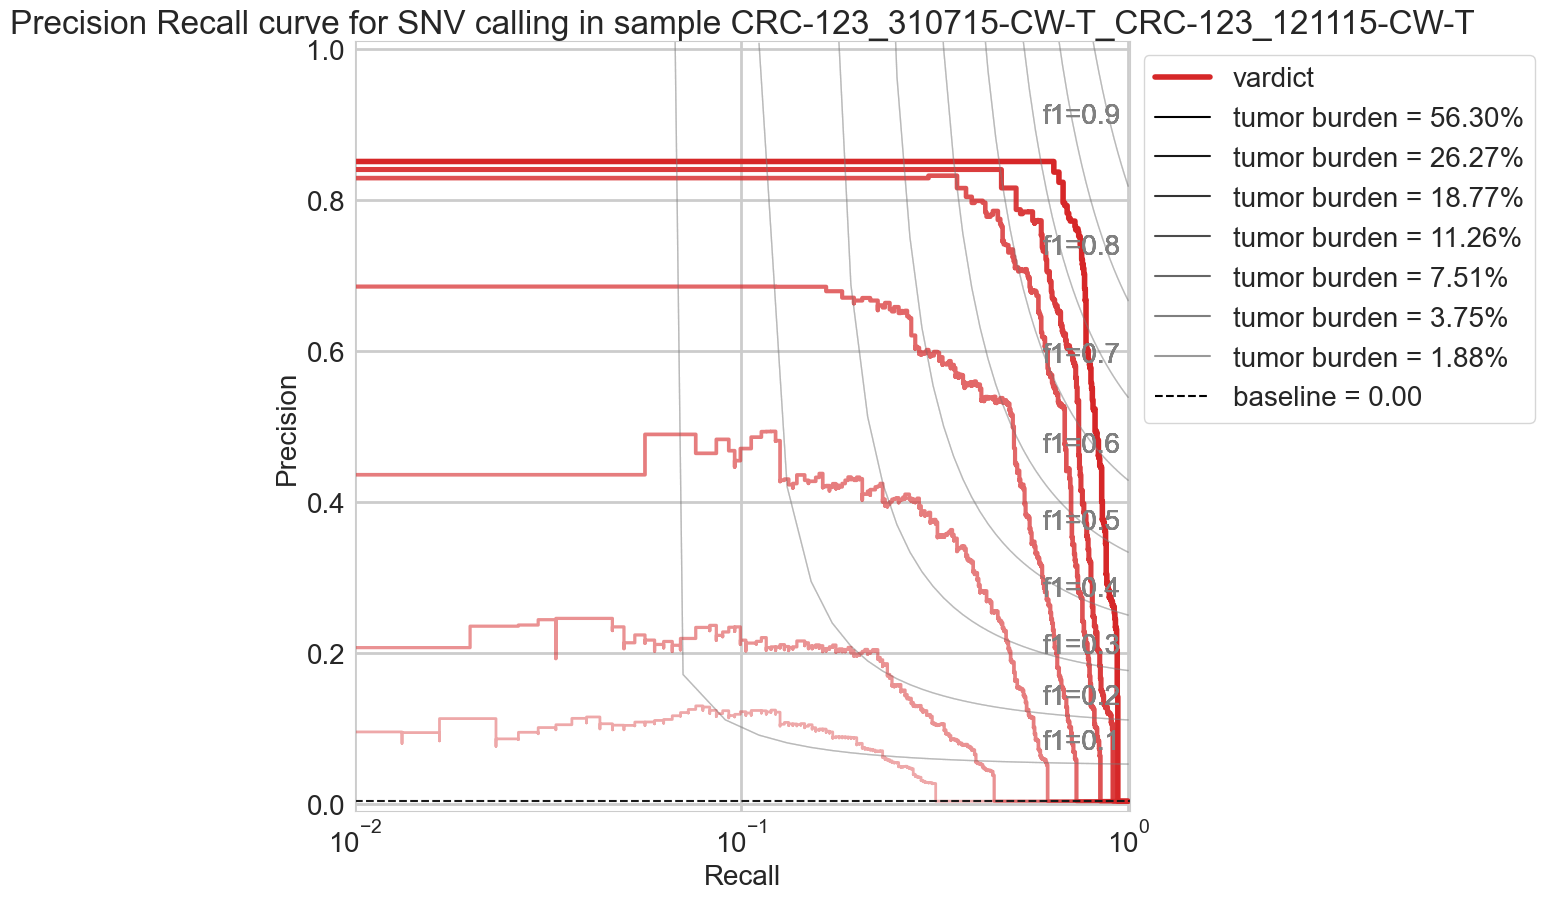

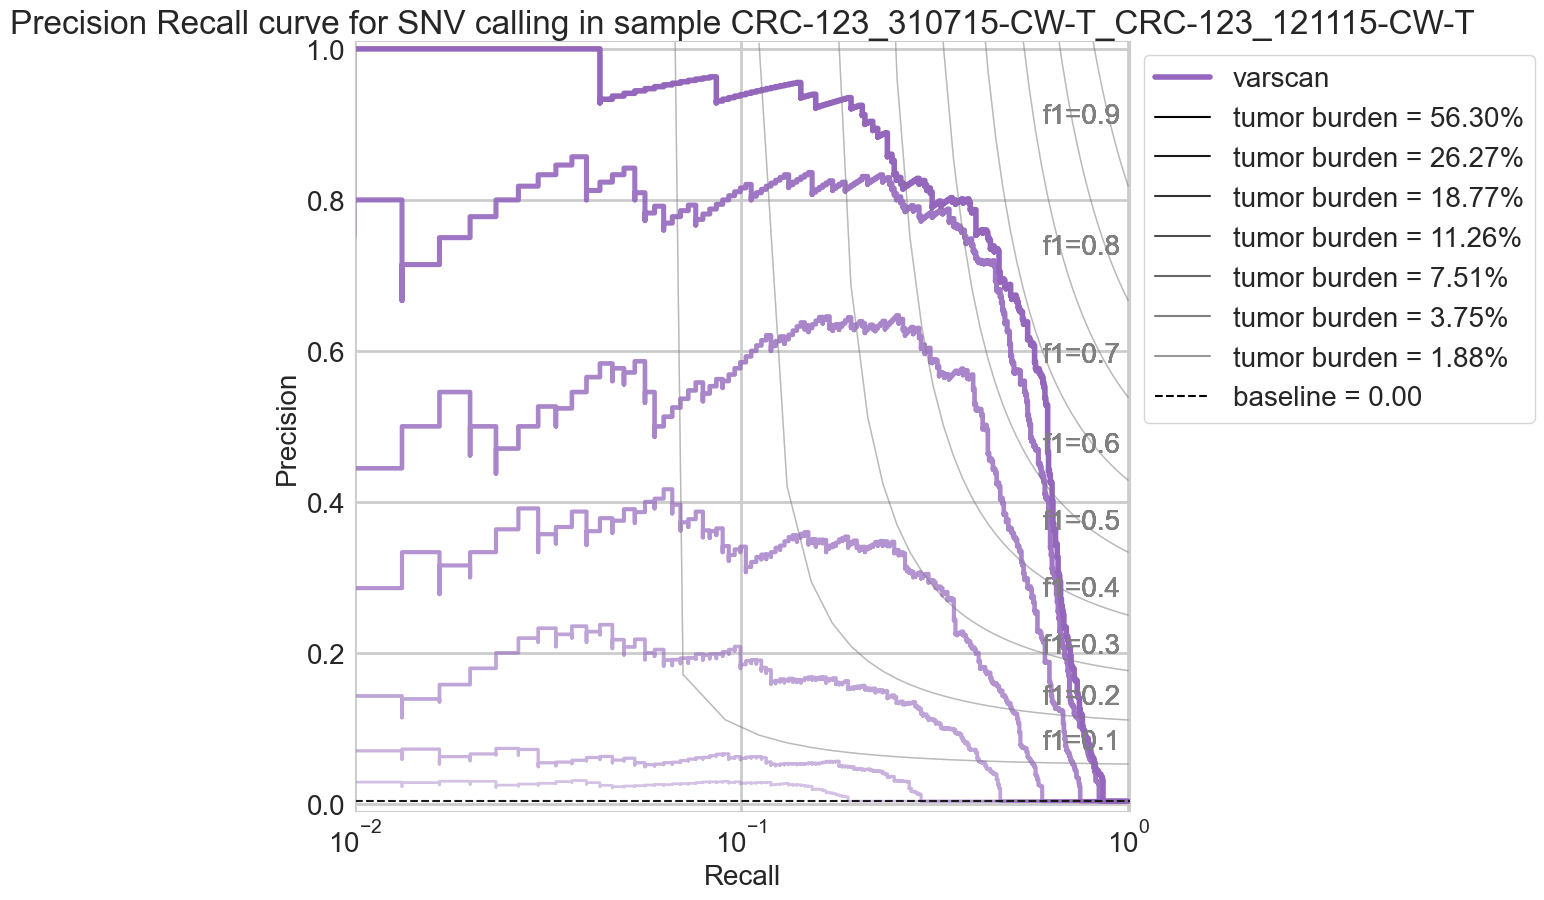

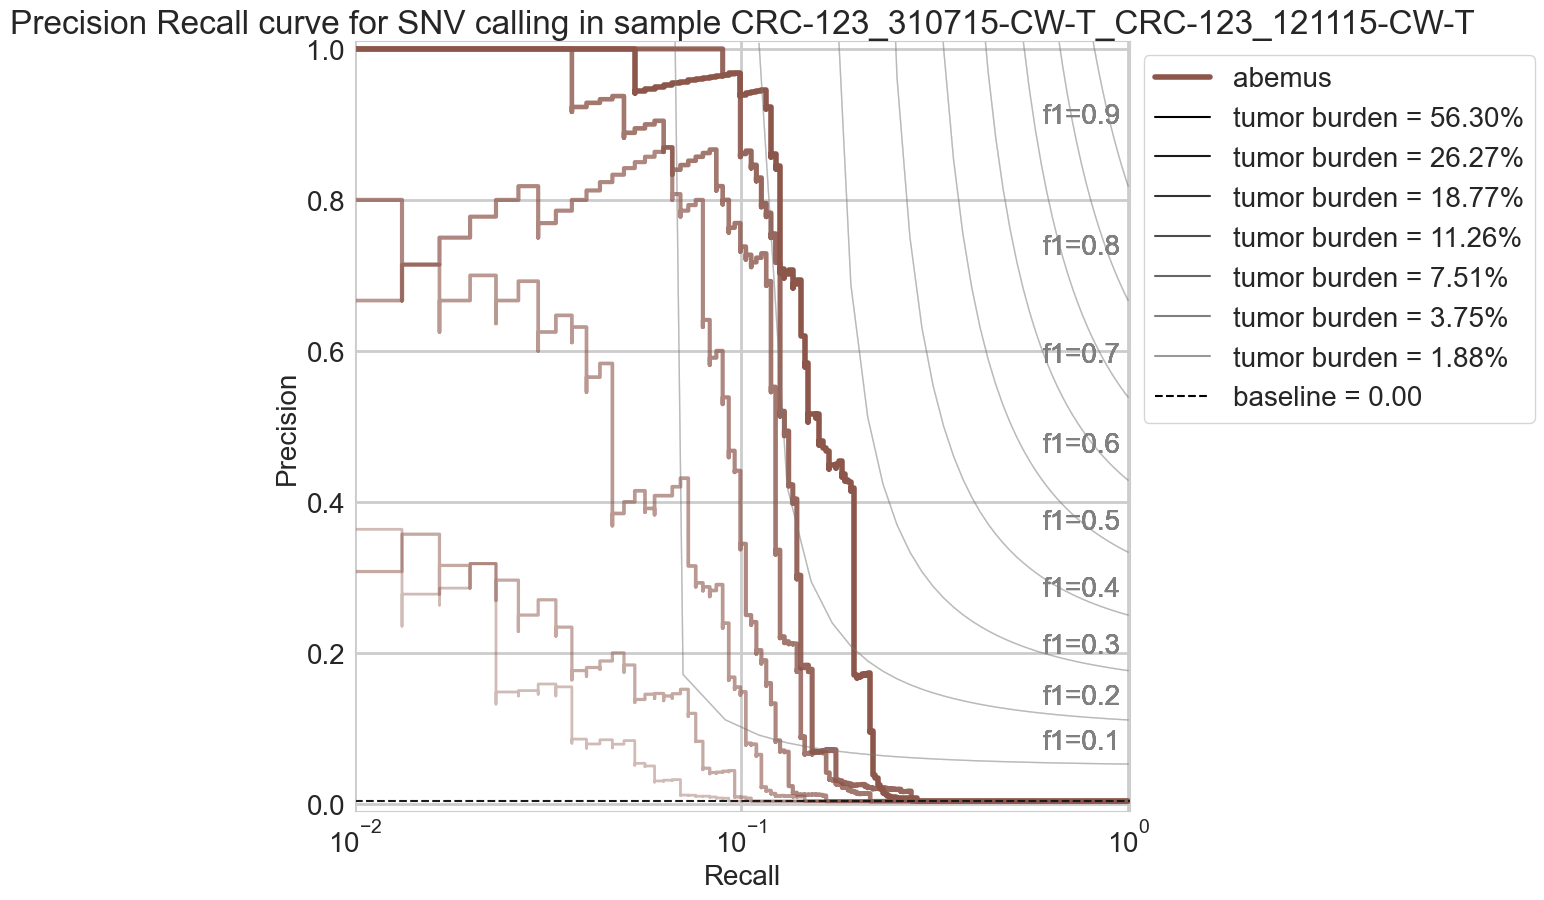

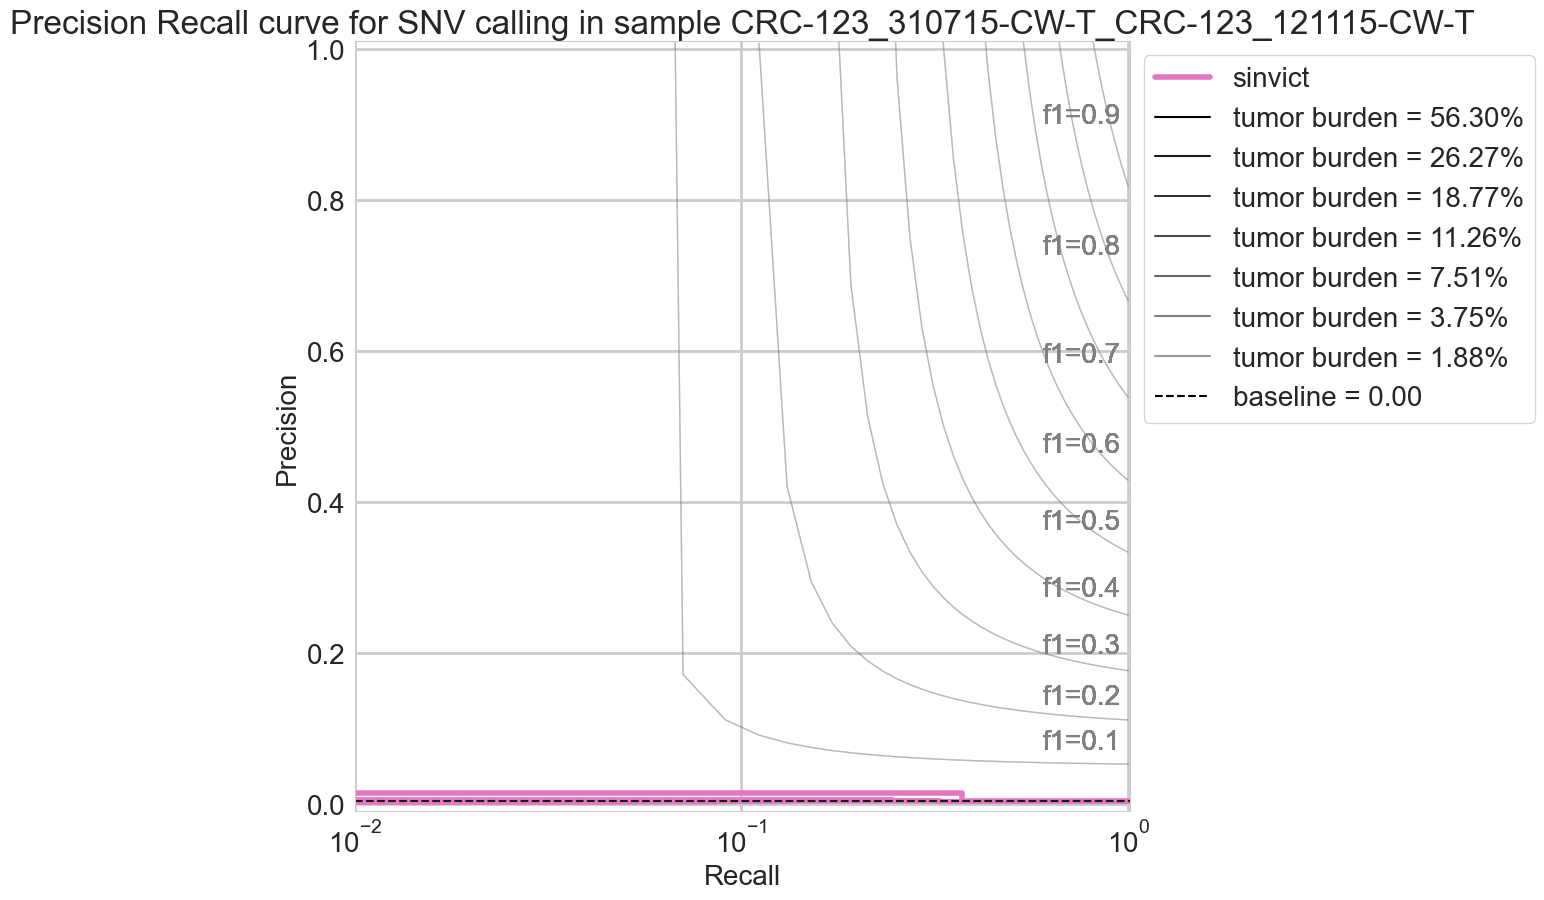

In [13]:
fixedvar = 'coverage'
#for fixedvar in fixedvars:
if fixedvar == 'coverage':
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(70, 0), (70, 80), (70, 180)]
    xaxis = 'coverage'
#for mixtureid in mixtureids:
print('############# {} ############'.format(mixtureid))
if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=17 and c !=8 and c!=5 and c!=19 and c!=20 and c!=21 and c!=22]
elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] 
else:
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=6 and c!=20 and c!=21] 
calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
aux_all = []
calltable_snv, aux = get_calltableseries(config, mixtureid, chroms, muttype='snv', filterparam=filterparam, reload=reload, save=save)
calltable_indel, aux = get_calltableseries(config, mixtureid, chroms, muttype='indel', filterparam=filterparam, reload=reload, save=save)
calltable_snp, aux = get_calltableseries(config, mixtureid, chroms, muttype='snp', filterparam=filterparam, reload=reload, save=save)
print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
print(aux)
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)
calltables['snv'].append(calltable_snv)
calltables['indel'].append(calltable_indel)
calltables['snp'].append(calltable_snp)
calltables['sampleid'] = mixtureid 
calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
calltables['snv'] = pd.concat(calltables['snv'])
calltables['indel'] = pd.concat(calltables['indel'])
calltables['snp'] = pd.concat(calltables['snp'])
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
#for muttype in muttypes:
muttype = 'snv'
if muttype == 'snv':
    gtm = 4
else:  # elif muttype == 'indel':
    gtm = 2
print(max(aux['tf']))
calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype)
print(calltablesseries)
#results_auprc_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='auprc', ground_truth_method=gtm,
#                                 refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
#results_recall_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='recall', ground_truth_method=gtm,
#                                       refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
#results_precision_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='precision', ground_truth_method=gtm,
#                                      refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_recall_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='recall', ground_truth_method=gtm,
                                       refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='precision', ground_truth_method=gtm,
                                      refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
                    refsample='undiluted', muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=save)

############# CRC-1014_180816-CW-T_CRC-1014_090516-CW-T ############
['1', '2', '3', '4', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '18']
mixture ['data', 'mixtures']
mixture_chr1_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x
mixture_chr1_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 19
strelka2
retrieving strelka2 0 calls with MinAF tags out of 76
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 465
varscan
abemus
sinvict
# calls before using germline calls from GATK Haplotype: 3095 SNV, 83 INDEL, 3216 SNP
# calls after using germline calls from GATK Haplotype: 3095 SNV, 82 INDEL, 3217 SNP
final shape SNV: (3095, 40)
final shape INDEL: (82, 40)
final shape SNP: (3217, 40)
mixture_chr1_CRC-1014_180816-CW-T_5x_CRC-1014_090516-CW-T_145x
mixture_chr1_CRC-1014_180816-CW-T_5x_CRC-1014_090516-CW-T_145x
freebayes
mutect2
retrieving mutect2 0 calls with MinAF tags out of 10
strelka2


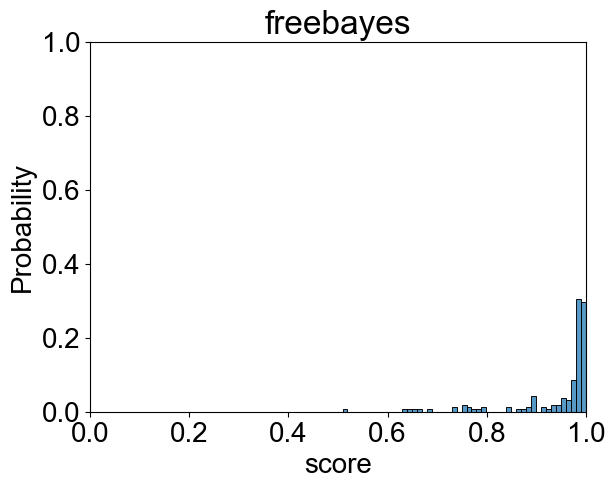

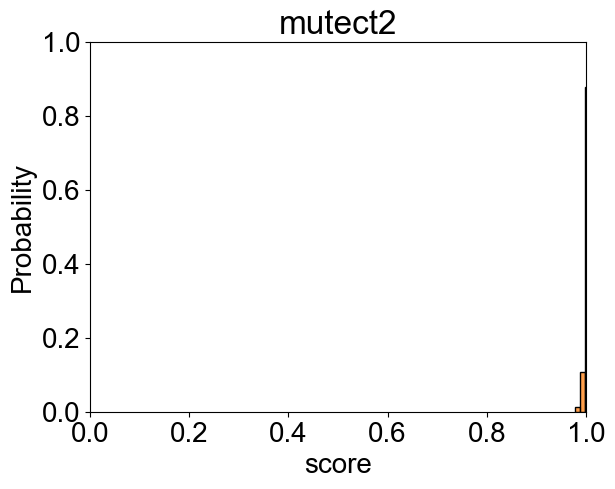

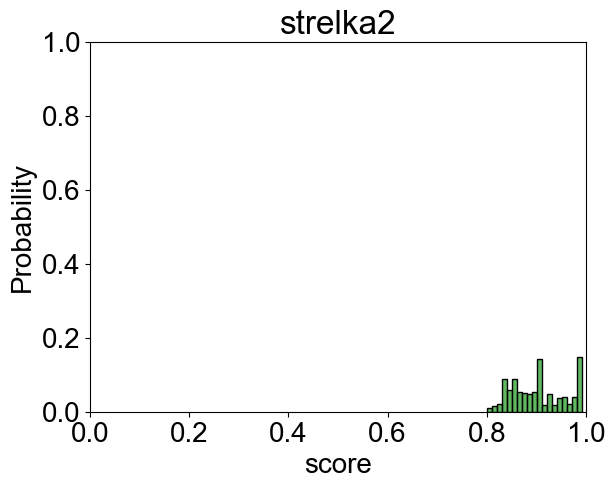

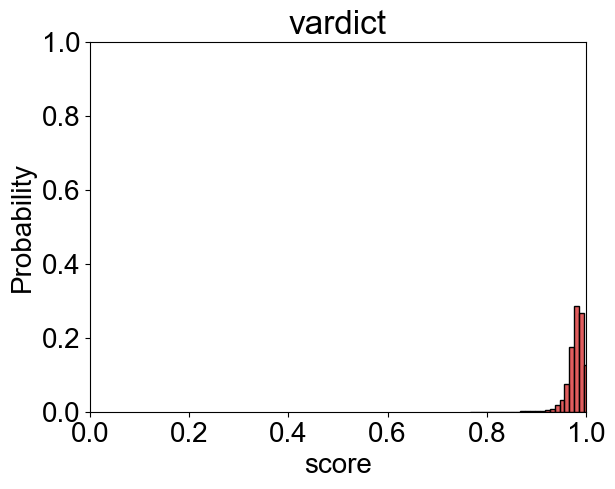

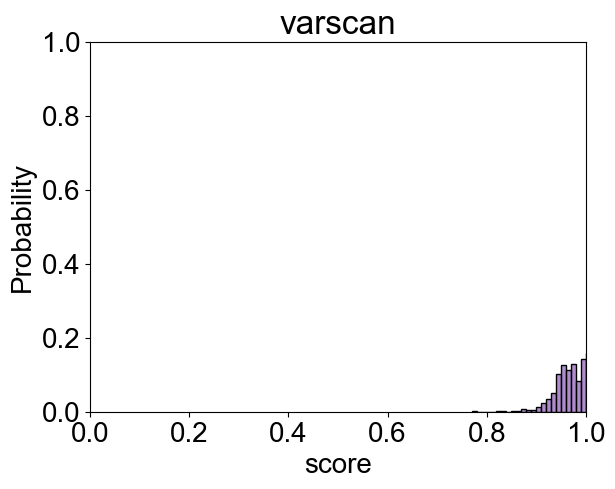

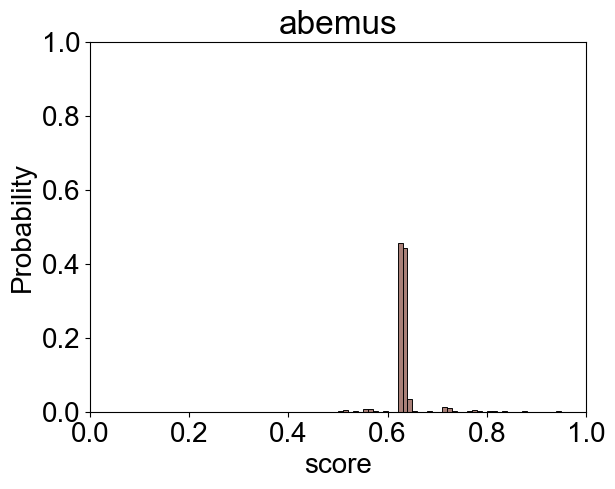

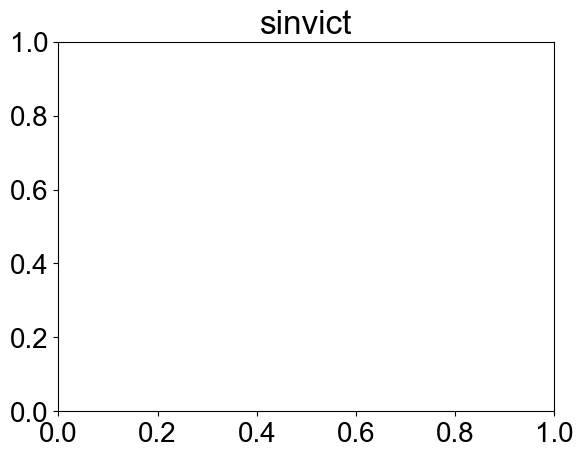

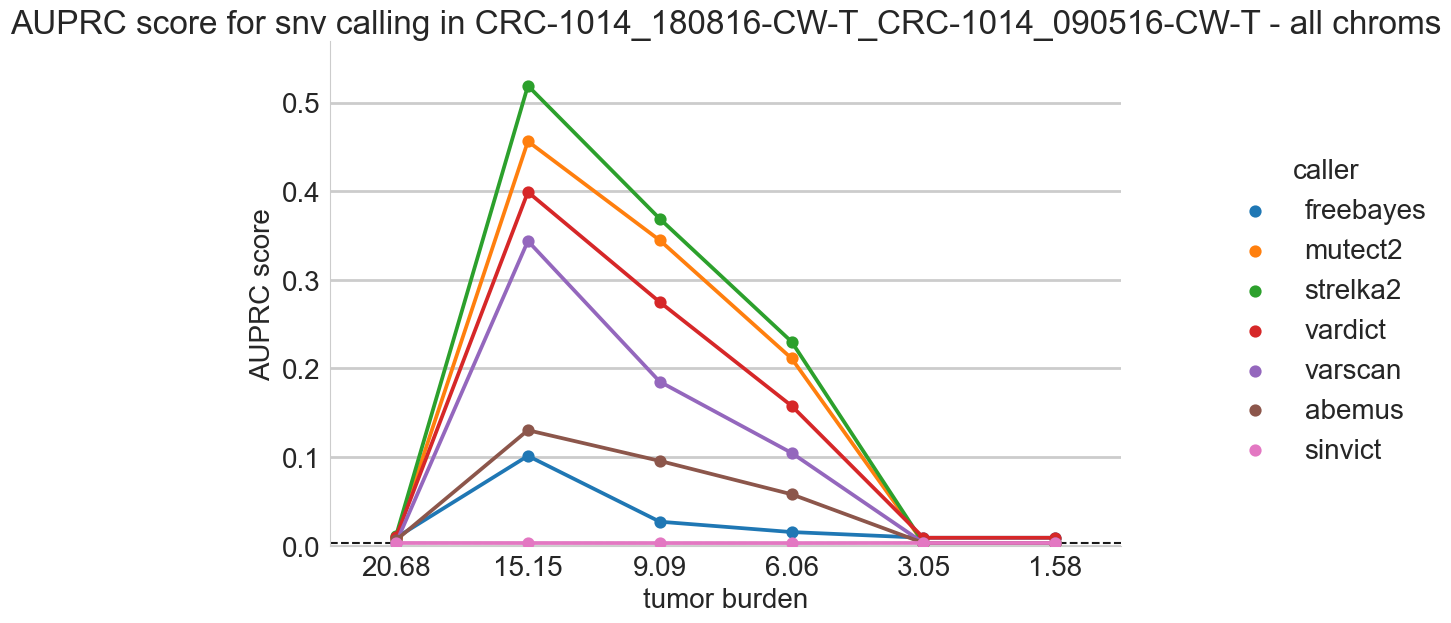

mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x
45.45_freebayes_score
is present
45.45_mutect2_score
is present
45.45_strelka2_score
is present
45.45_vardict_score
is present
45.45_varscan_score
is present
45.45_abemus_score
is present
45.45_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x
20.68_freebayes_score
is present
20.68_mutect2_score
is present
20.68_strelka2_score
is present
20.68_vardict_score
is present
20.68_varscan_score
is present
20.68_abemus_score
is present
20.68_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_50x_CRC-1014_090516-CW-T_100x
15.15_freebayes_score
is present
15.15_mutect2_score
is present
15.15_strelka2_score
is present
15.15_vardict_score
is present
15.15_varscan_score
is present
15.15_abemus_score
is present
15.15_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x
9.09_freebayes_score
is present
9.09_mutect2_score
is present
9.09_strelka2_score
is p

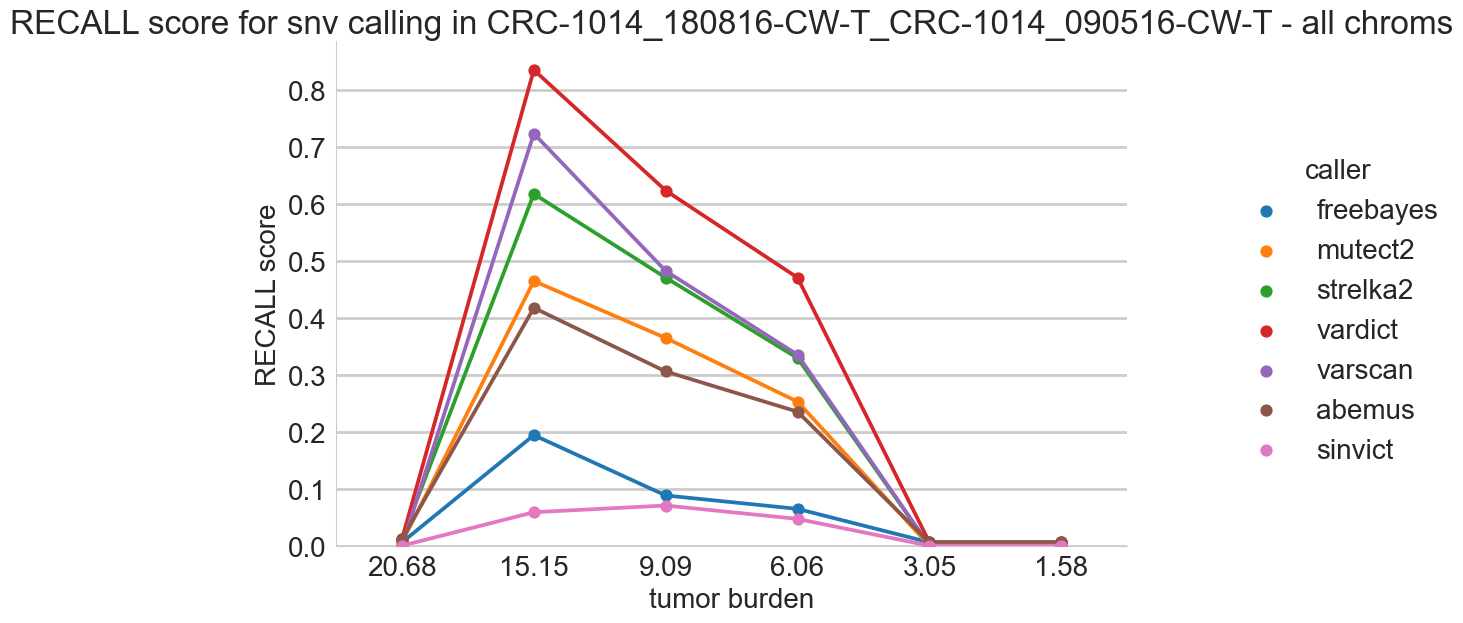

mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x
45.45_freebayes_score
is present
45.45_mutect2_score
is present
45.45_strelka2_score
is present
45.45_vardict_score
is present
45.45_varscan_score
is present
45.45_abemus_score
is present
45.45_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x
20.68_freebayes_score
is present
20.68_mutect2_score
is present
20.68_strelka2_score
is present
20.68_vardict_score
is present
20.68_varscan_score
is present
20.68_abemus_score
is present
20.68_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_50x_CRC-1014_090516-CW-T_100x
15.15_freebayes_score
is present
15.15_mutect2_score
is present
15.15_strelka2_score
is present
15.15_vardict_score
is present
15.15_varscan_score
is present
15.15_abemus_score
is present
15.15_sinvict_score
is present
mixture_chr18_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x
9.09_freebayes_score
is present
9.09_mutect2_score
is present
9.09_strelka2_score
is p

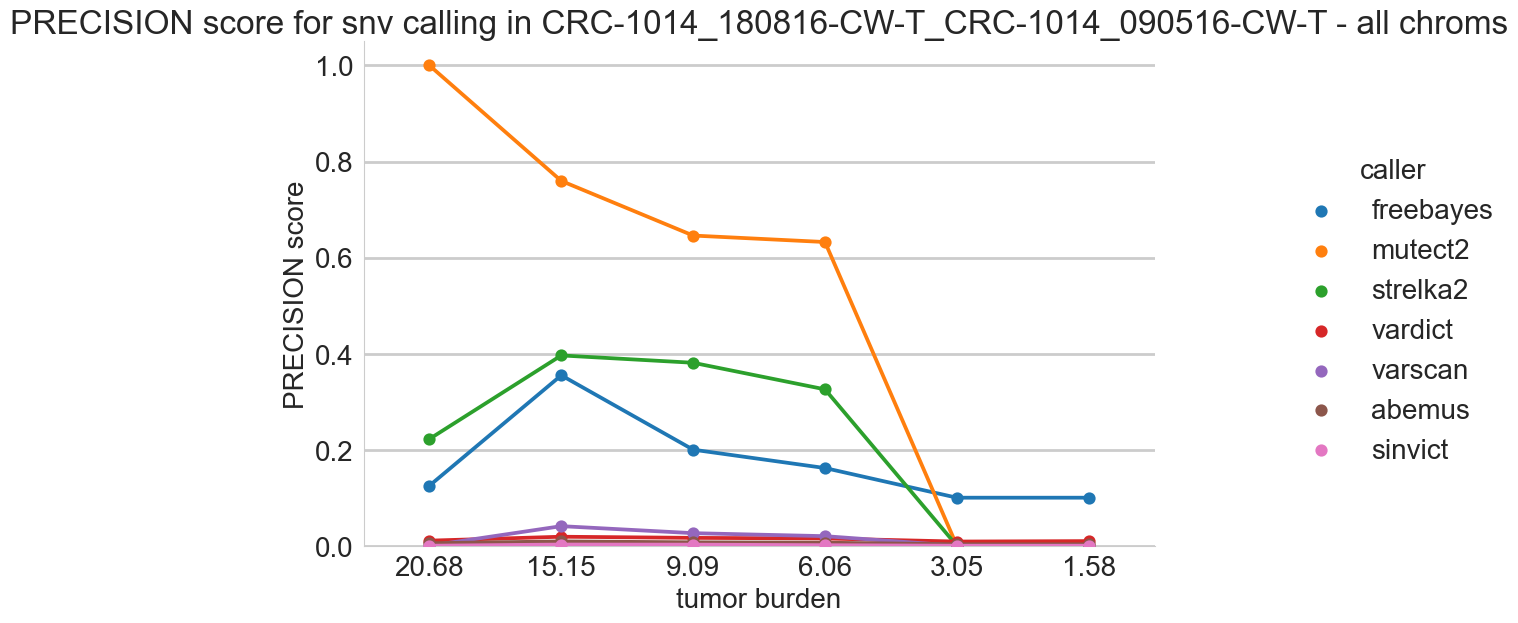

['mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x', 'mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x', 'mixture_chr18_CRC-1014_180816-CW-T_50x_CRC-1014_090516-CW-T_100x', 'mixture_chr18_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x', 'mixture_chr18_CRC-1014_180816-CW-T_20x_CRC-1014_090516-CW-T_130x', 'mixture_chr18_CRC-1014_180816-CW-T_10x_CRC-1014_090516-CW-T_140x', 'mixture_chr18_CRC-1014_180816-CW-T_5x_CRC-1014_090516-CW-T_145x']
45.45_freebayes_score
20.68_freebayes_score
15.15_freebayes_score
9.09_freebayes_score
6.06_freebayes_score
3.05_freebayes_score
1.58_freebayes_score
['mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_0x', 'mixture_chr18_CRC-1014_180816-CW-T_70x_CRC-1014_090516-CW-T_80x', 'mixture_chr18_CRC-1014_180816-CW-T_50x_CRC-1014_090516-CW-T_100x', 'mixture_chr18_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x', 'mixture_chr18_CRC-1014_180816-CW-T_20x_CRC-1014_090516-CW-T_130x', 'mixture_chr18_CRC-1014_180816-CW-T_10x

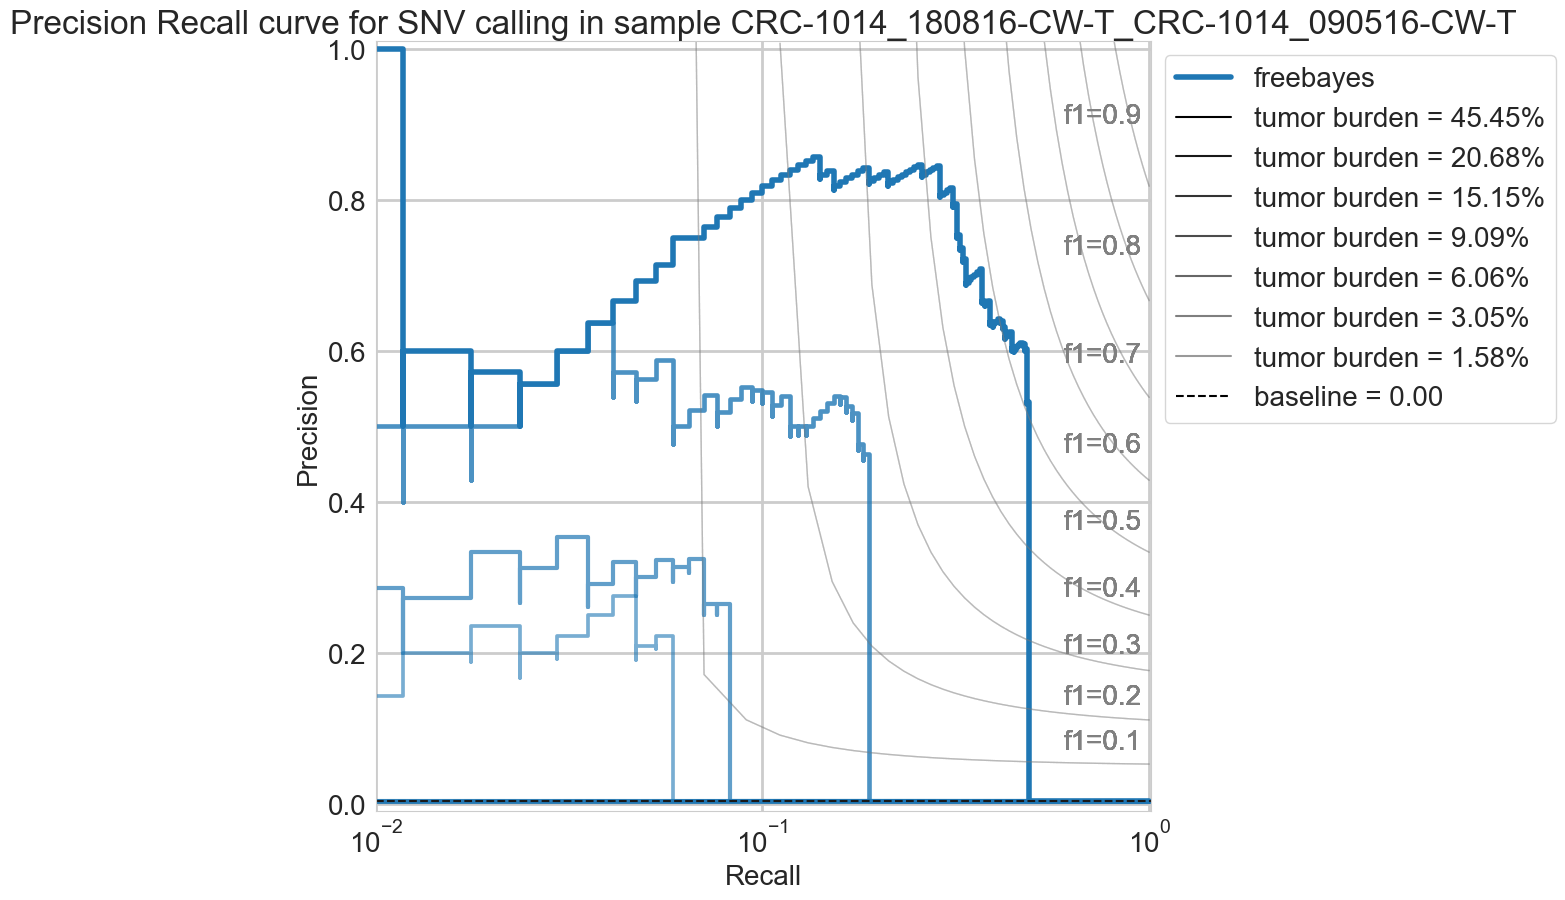

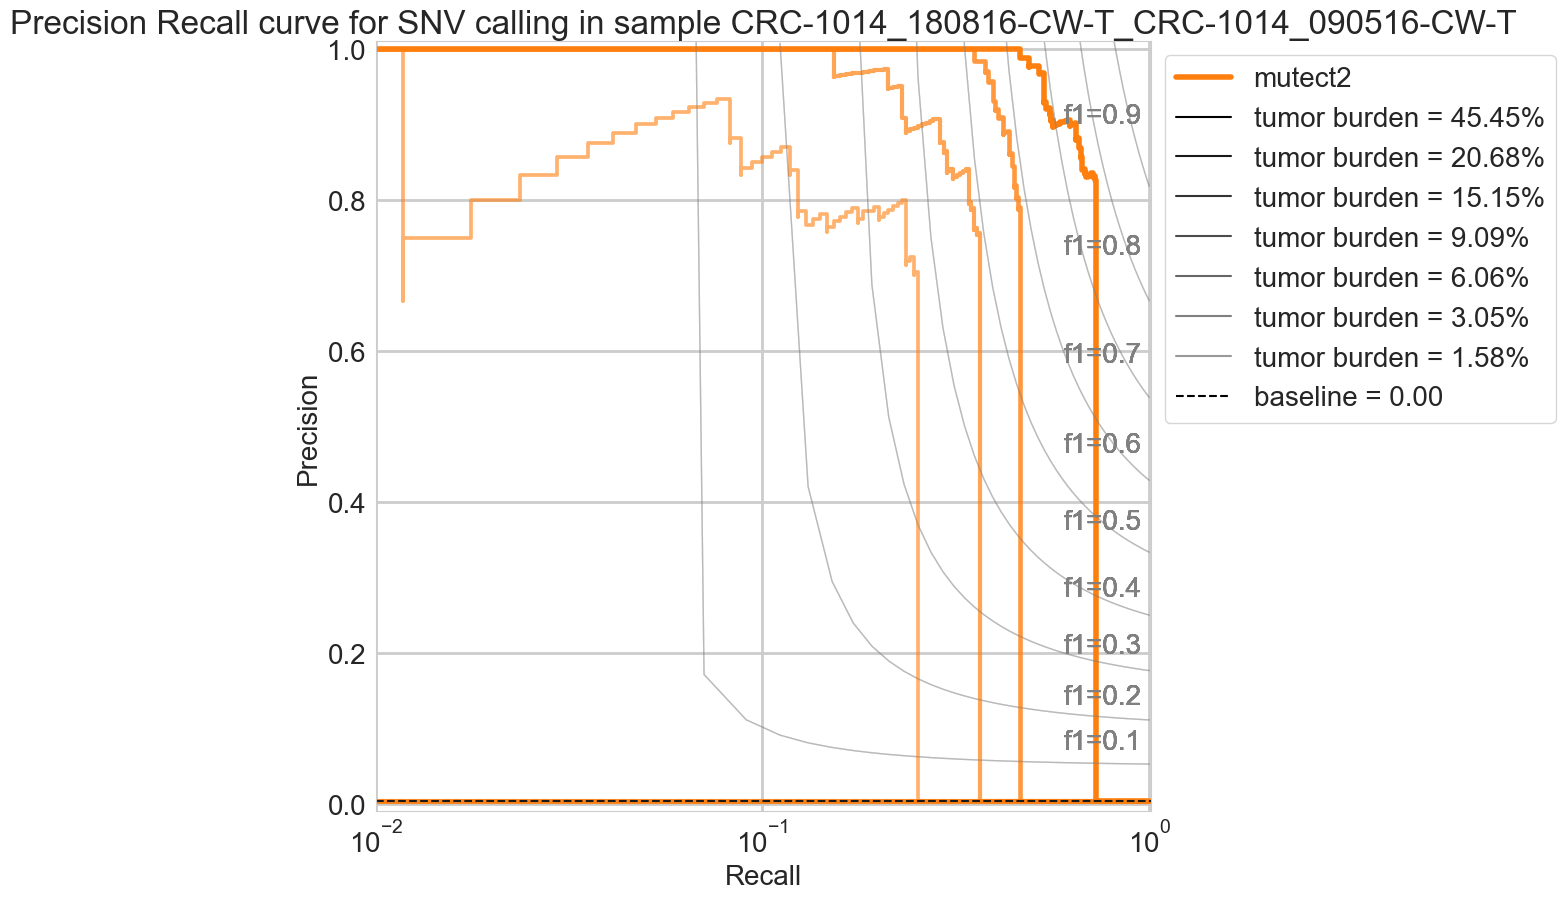

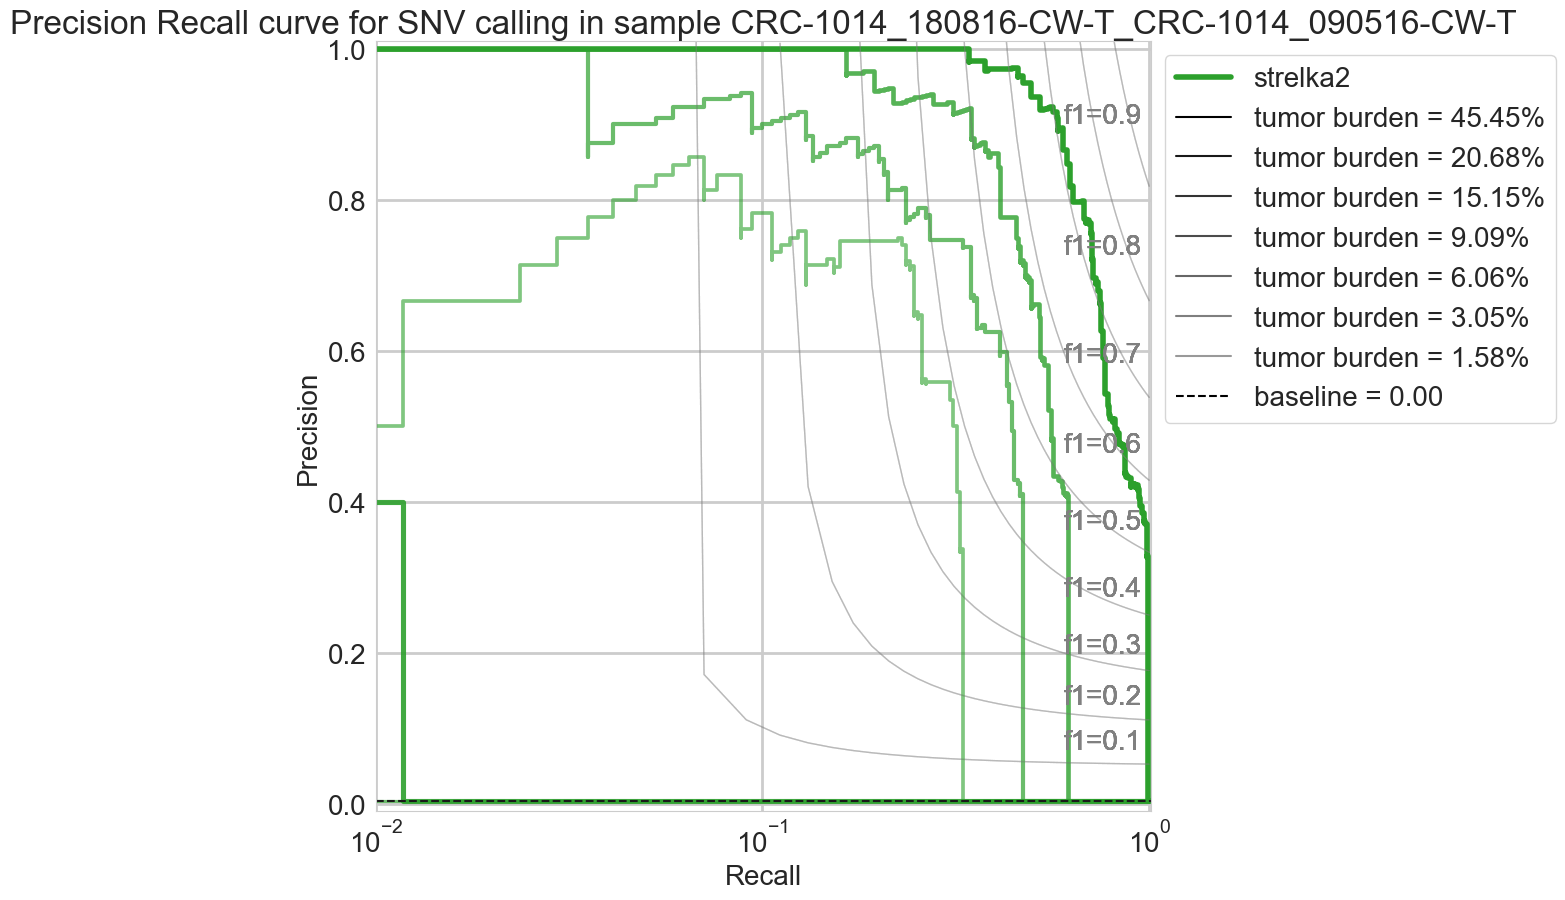

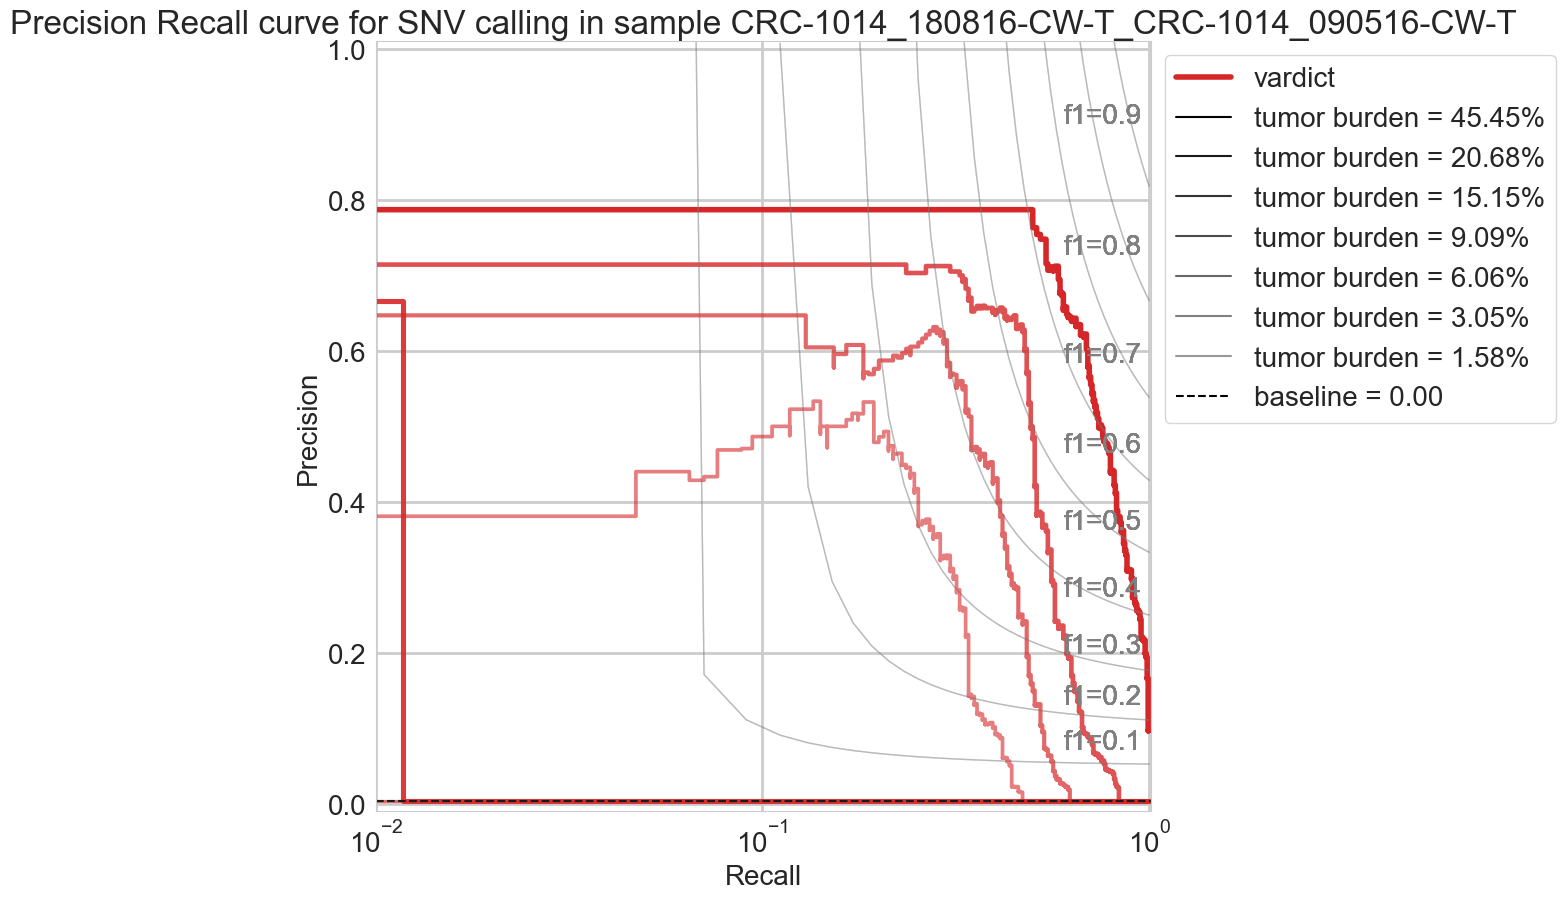

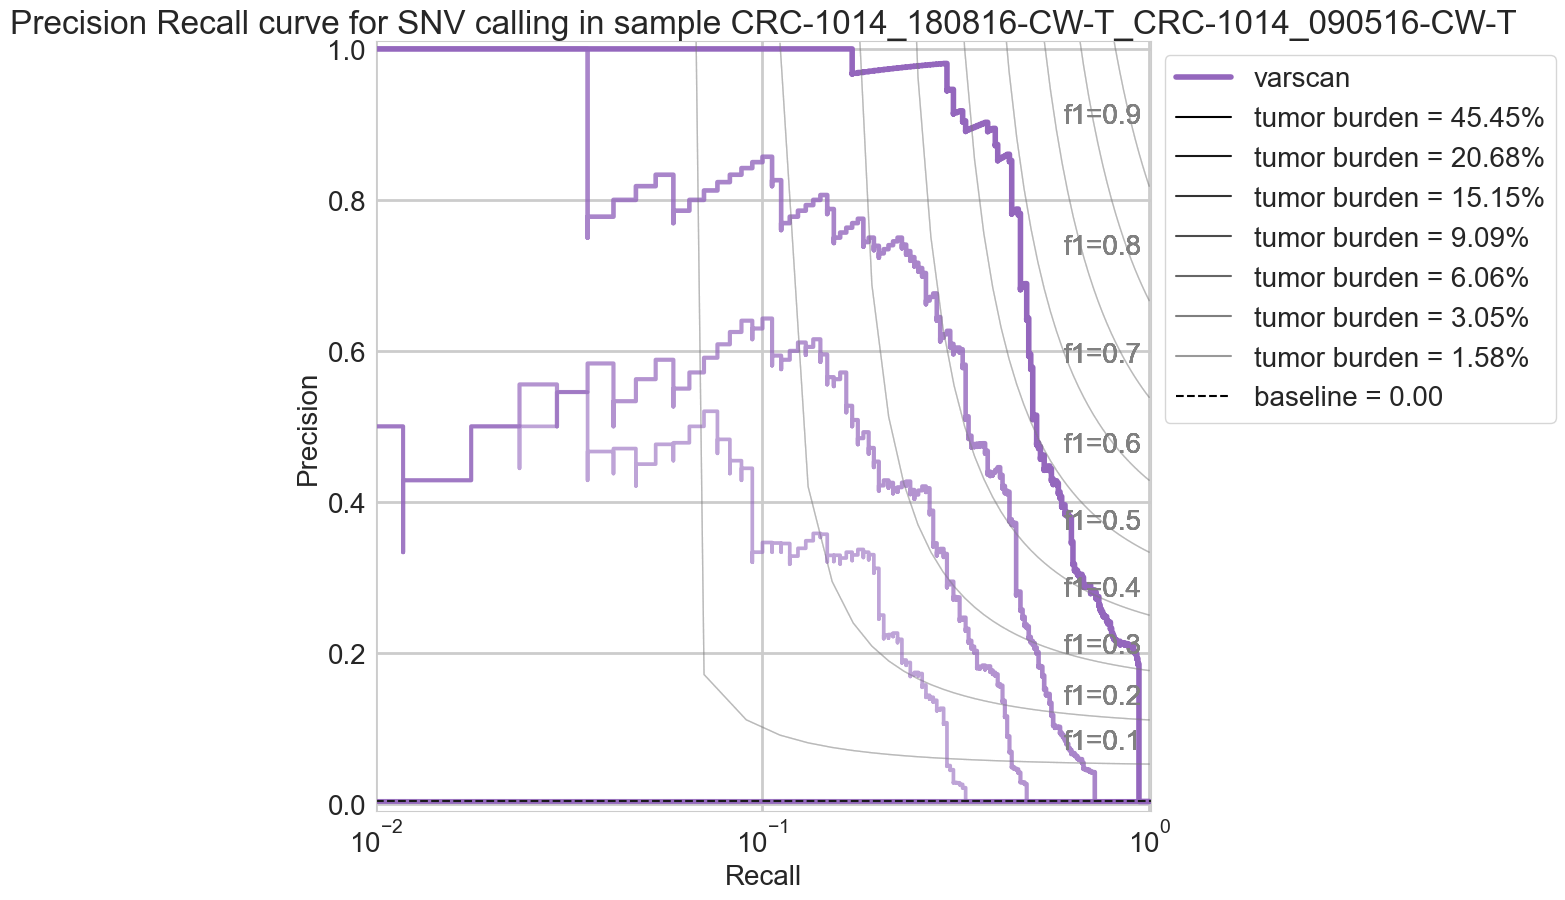

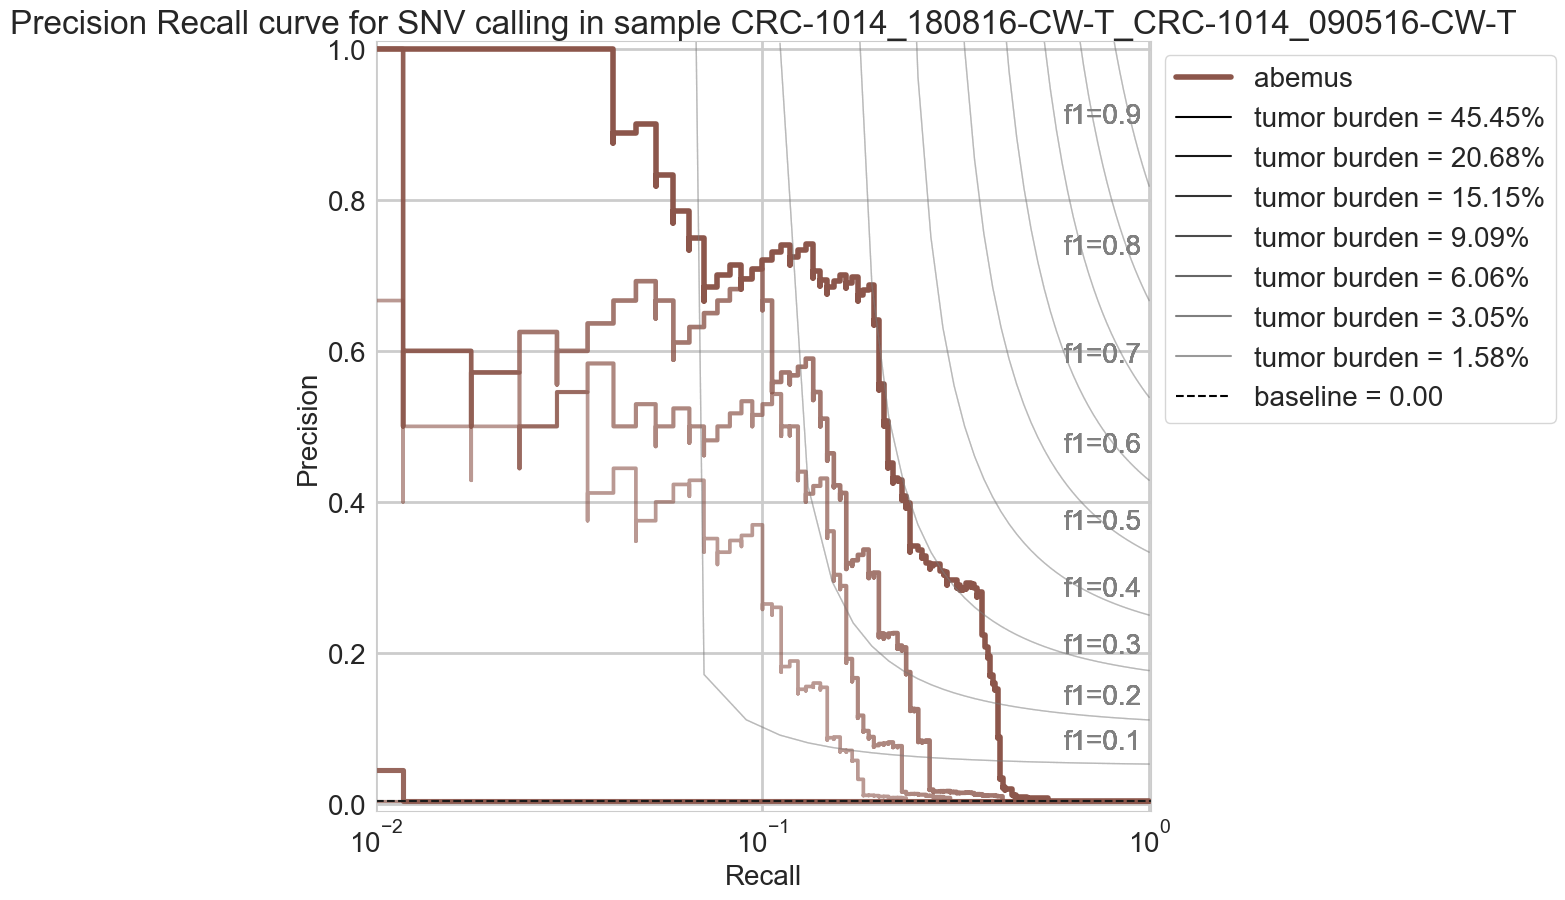

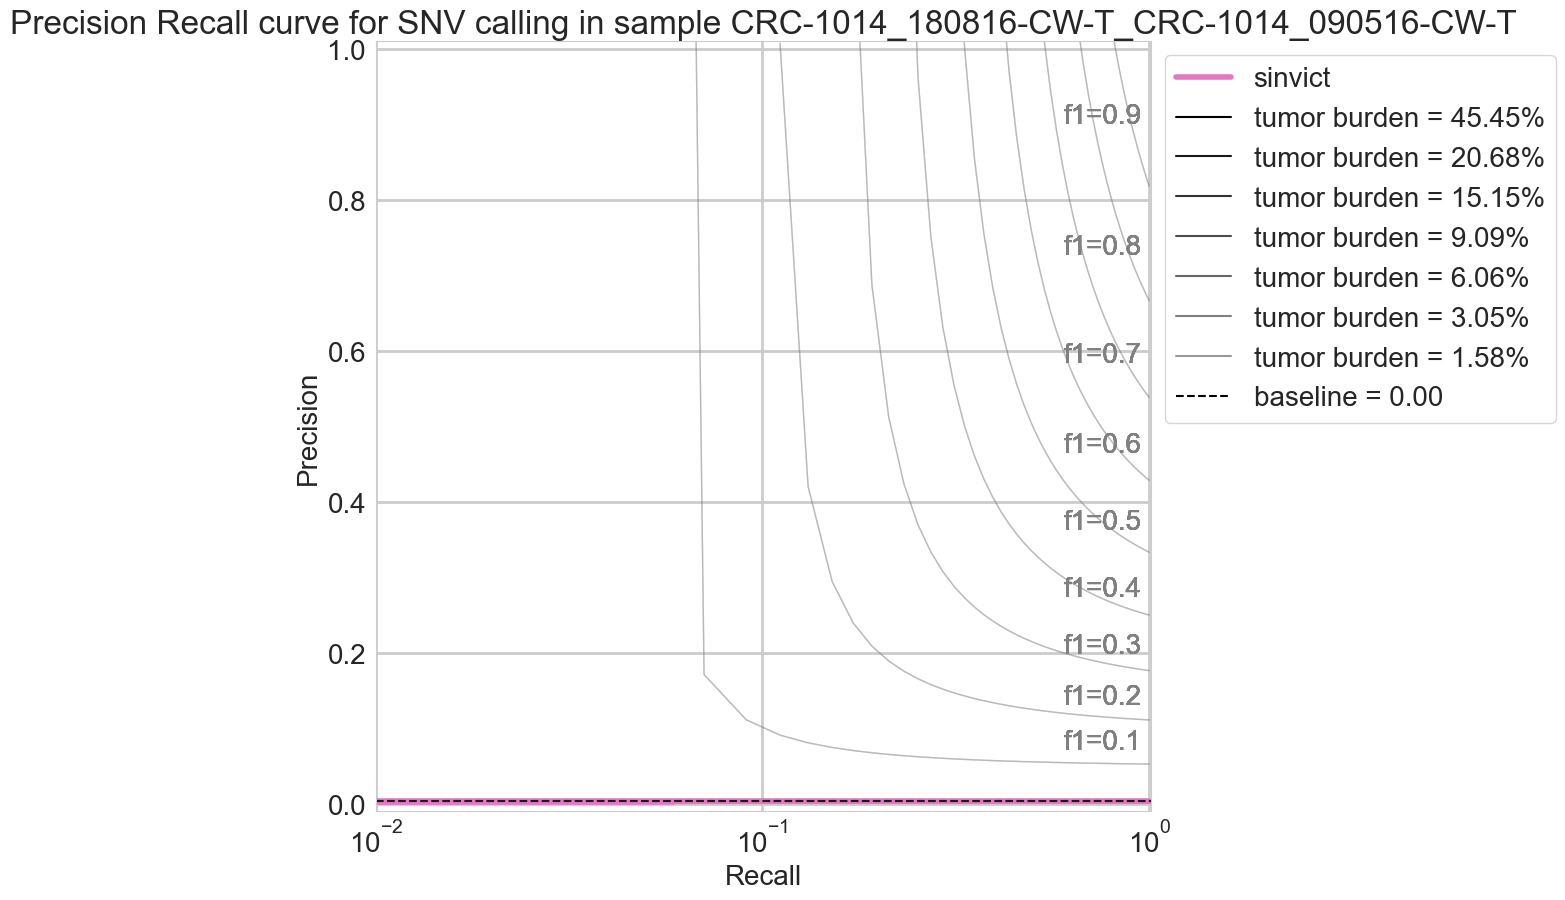

In [4]:
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
fixedvar = 'coverage'
#for fixedvar in fixedvars:
if fixedvar == 'coverage':
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(70, 0), (70, 80), (70, 180)]
    xaxis = 'coverage'
#for mixtureid in mixtureids:
print('############# {} ############'.format(mixtureid))
if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=17 and c !=8 and c!=5 and c!=19 and c!=20 and c!=21 and c!=22]
elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] # c !=1 and c!= 2 
else:
    chroms = [str(c) for c in range(1,23)]
print(chroms)
calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
aux_all = []
for chrom in chroms:
    calltable_snv, aux = get_calltableseries(config, mixtureid, chrom, muttype='snv', filterparam=filterparam, reload=reload, save=save)
    calltable_indel, aux = get_calltableseries(config, mixtureid, chrom, muttype='indel', filterparam=filterparam, reload=reload, save=save)
    calltable_snp, aux = get_calltableseries(config, mixtureid, chrom, muttype='snp', filterparam=filterparam, reload=reload, save=save)
    print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
    #dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
    dilutionseries = aux.T[['mixture_chr' + str(chrom) + '_' +  '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
    print(dilutionseries)
    plasmasample = '_'.join(mixtureid.split('_')[:2])
    print(plasmasample)
    healthysample = '_'.join(mixtureid.split('_')[2:])
    print(healthysample)
    calltables['snv'].append(calltable_snv)
    calltables['indel'].append(calltable_indel)
    calltables['snp'].append(calltable_snp)
    calltables['sampleid'] = mixtureid 
    calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
calltables['snv'] = pd.concat(calltables['snv'])
calltables['indel'] = pd.concat(calltables['indel'])
calltables['snp'] = pd.concat(calltables['snp'])
#for muttype in muttypes:
muttype = 'snv'
if muttype == 'snv':
    gtm = 4
else:  # elif muttype == 'indel':
    gtm = 2
print(max(aux['tf']))
calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype)
print(calltablesseries)
#results_auprc_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='auprc', ground_truth_method=gtm,
#                                 refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
#results_recall_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='recall', ground_truth_method=gtm,
#                                       refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
#results_precision_df = metric_curve(config, calltablesseries, plasmasample, healthysample, seriesorder, metric='precision', ground_truth_method=gtm,
#                                      refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, fixedvar=fixedvar)
results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_recall_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='recall', ground_truth_method=gtm,
                                       refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='precision', ground_truth_method=gtm,
                                      refsample='undiluted', muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
                    refsample='undiluted', muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=save)

In [ ]:
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
                    refsample='undiluted', muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=save)

In [ ]:
for tf in np.sort([round(i, 2)for i in aux['tf'].values])[::-1]:
    colselect = [c for c in list(calltablesseries.columns) for m in config.methods if str(tf)+'_'+m == c]
    print(calltablesseries[calltablesseries['truth'] == True][colselect].sum())

In [ ]:
colselect = [c for c in list(calltablesseries.columns) for m in config.methods if '19.55_'+m == c]
calltablesseries[calltablesseries['truth'] == True][colselect].sum()

# Part II: (4) Load back metric results and plot combined metric plots

['mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x', 'mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x', 'mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x', 'mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x', 'mixture_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x', 'mixture_CRC-123_310715-CW-T_10x_CRC-123_121115-CW-T_140x', 'mixture_CRC-123_310715-CW-T_5x_CRC-123_121115-CW-T_145x']
56.30_freebayes_score
26.27_freebayes_score
18.77_freebayes_score
11.26_freebayes_score
7.51_freebayes_score
3.75_freebayes_score
1.88_freebayes_score
['mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_0x', 'mixture_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_80x', 'mixture_CRC-123_310715-CW-T_50x_CRC-123_121115-CW-T_100x', 'mixture_CRC-123_310715-CW-T_30x_CRC-123_121115-CW-T_120x', 'mixture_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x', 'mixture_CRC-123_310715-CW-T_10x_CRC-123_121115-CW-T_140x', 'mixture_CRC-123_310715-CW-T_5x_CRC-123_121115-CW-T_145x']
56.30_mutect2_s

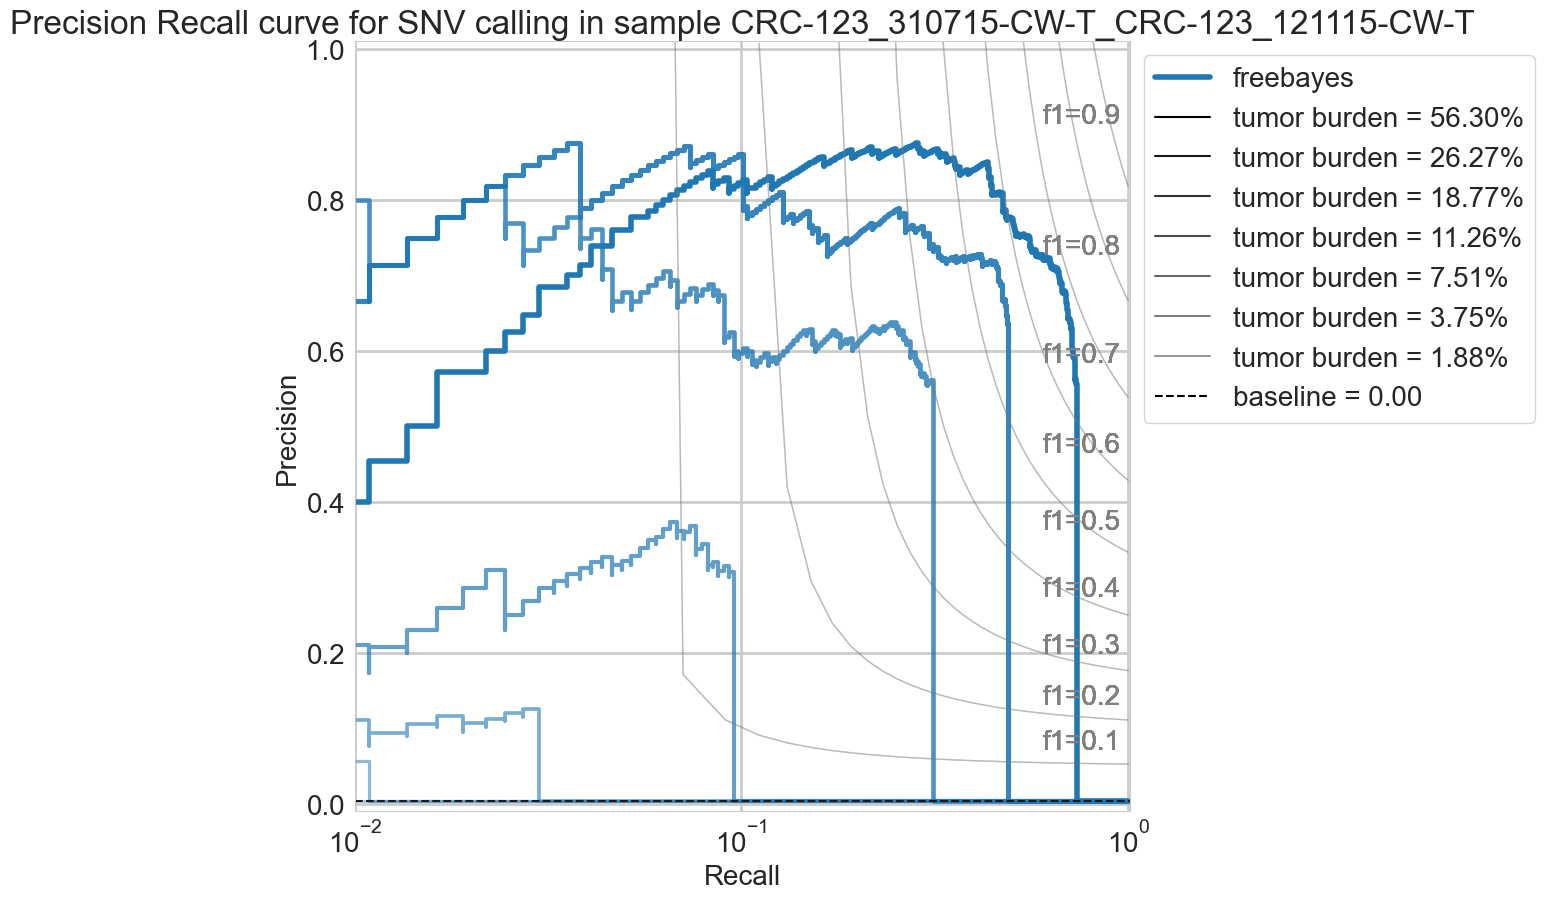

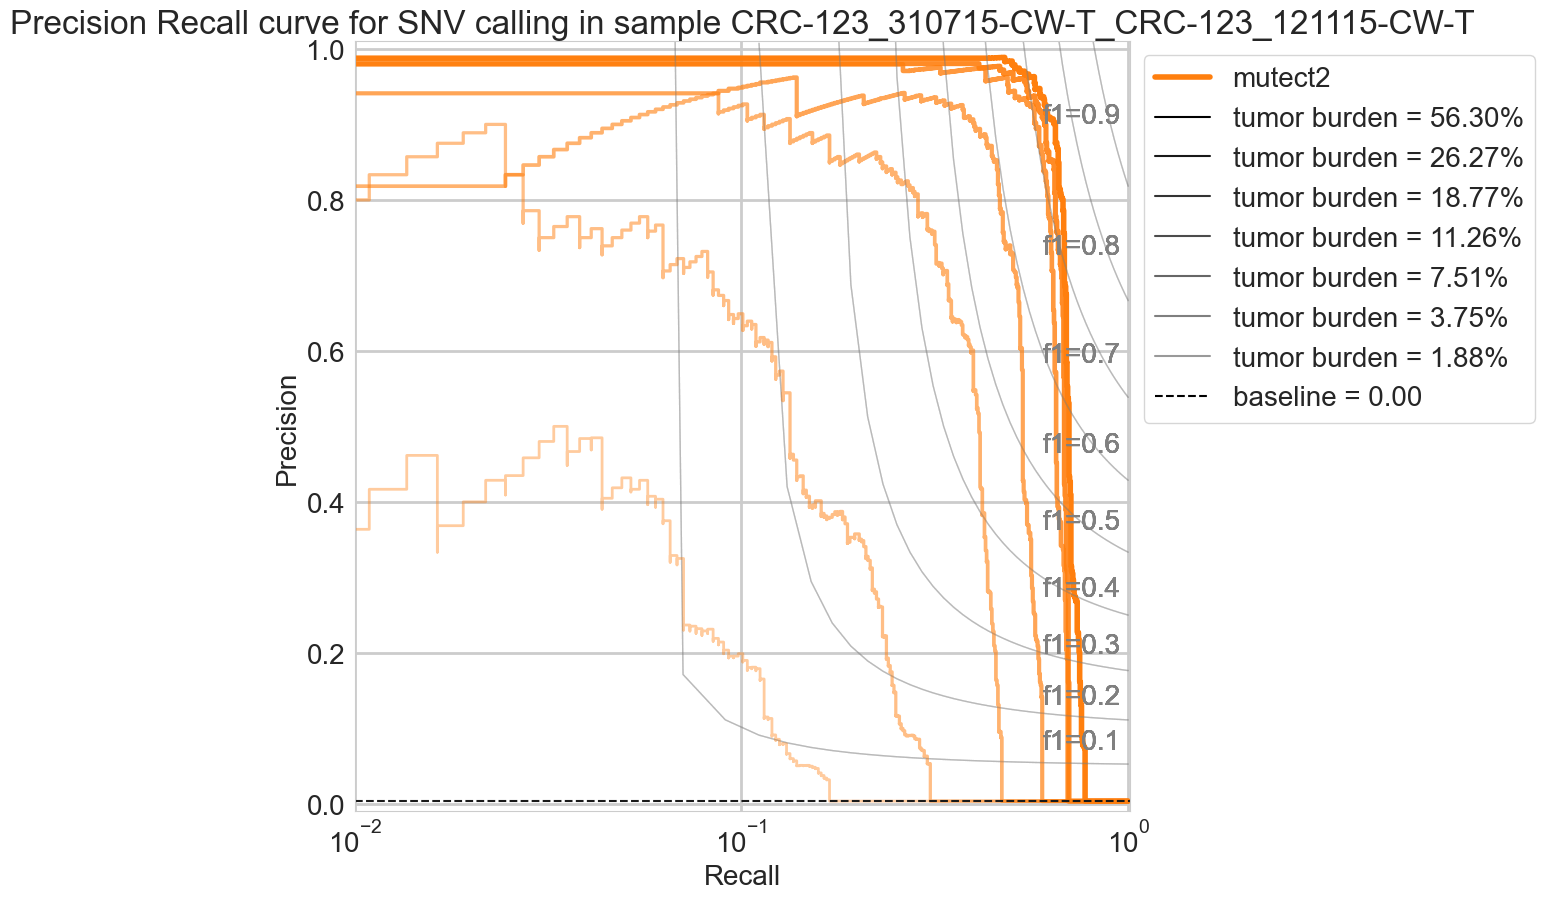

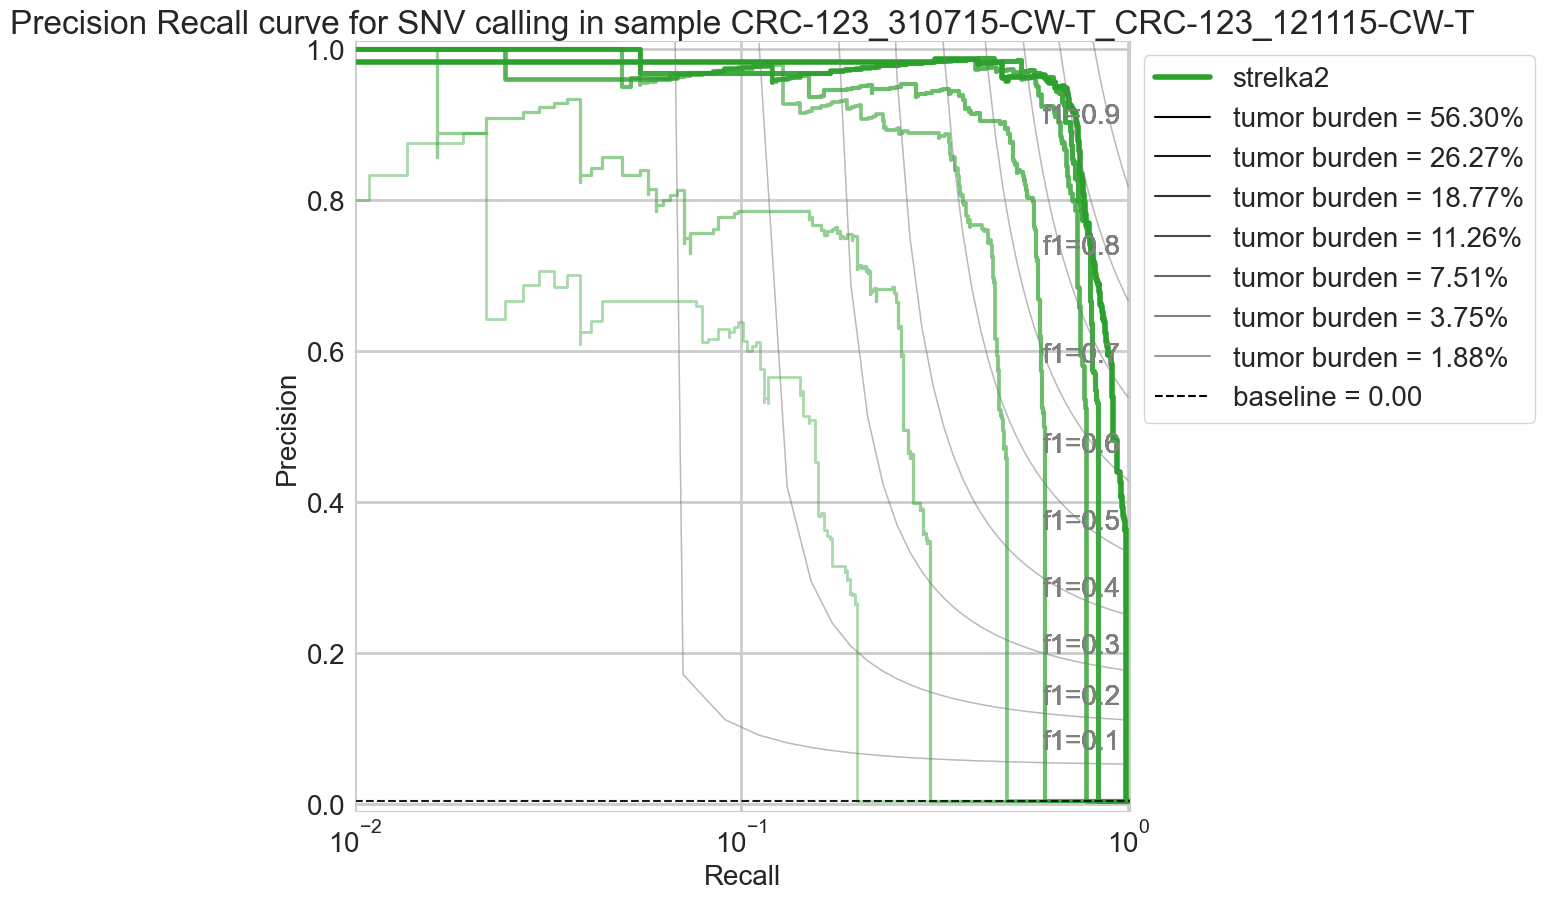

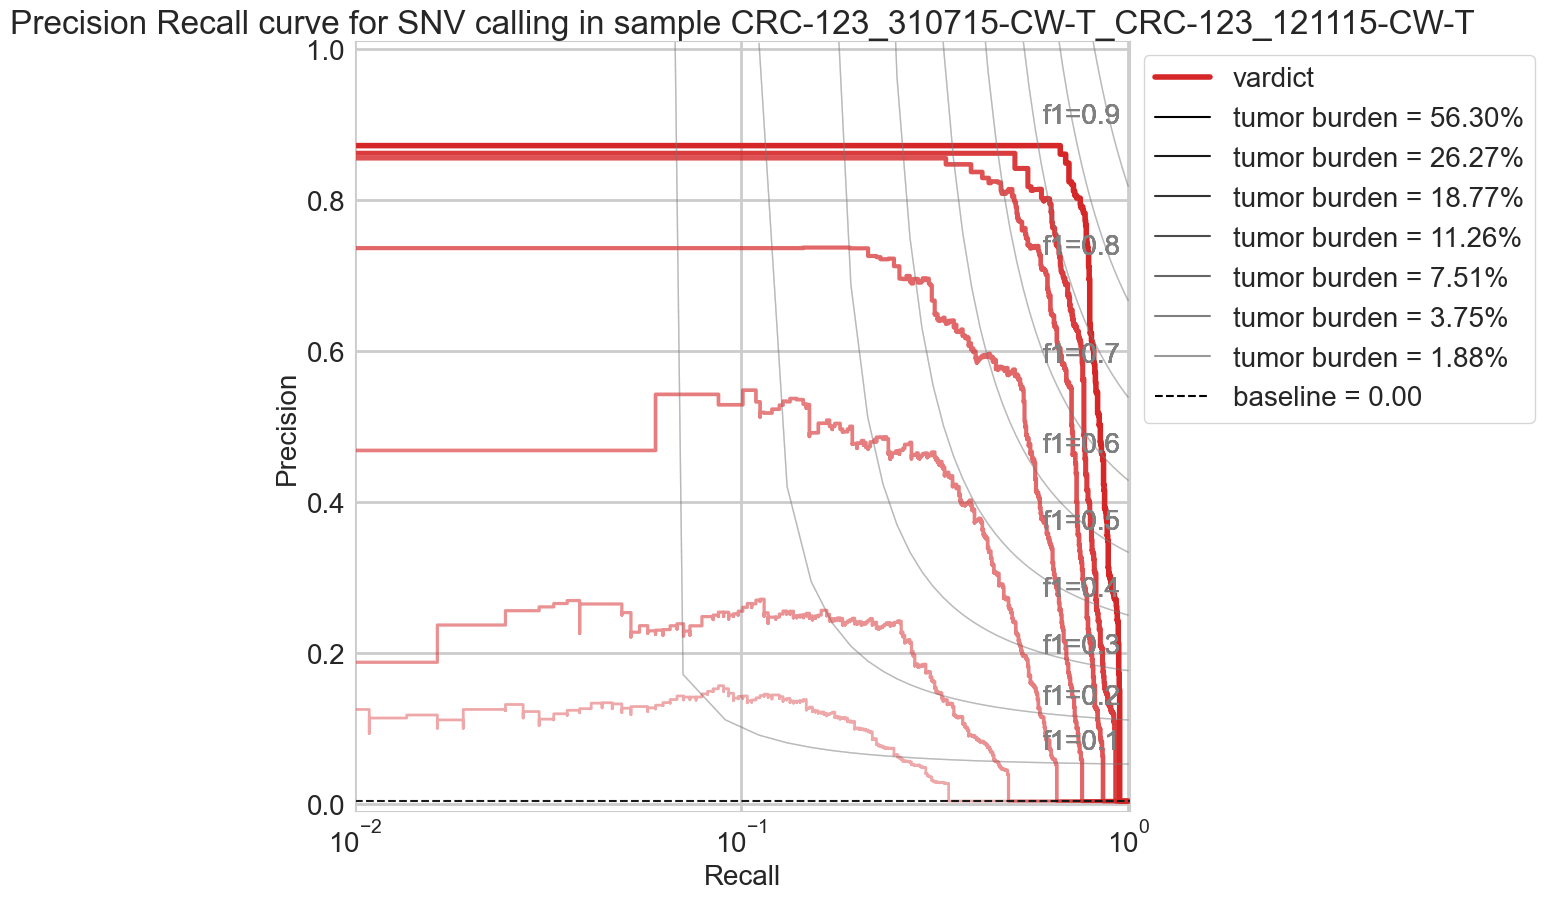

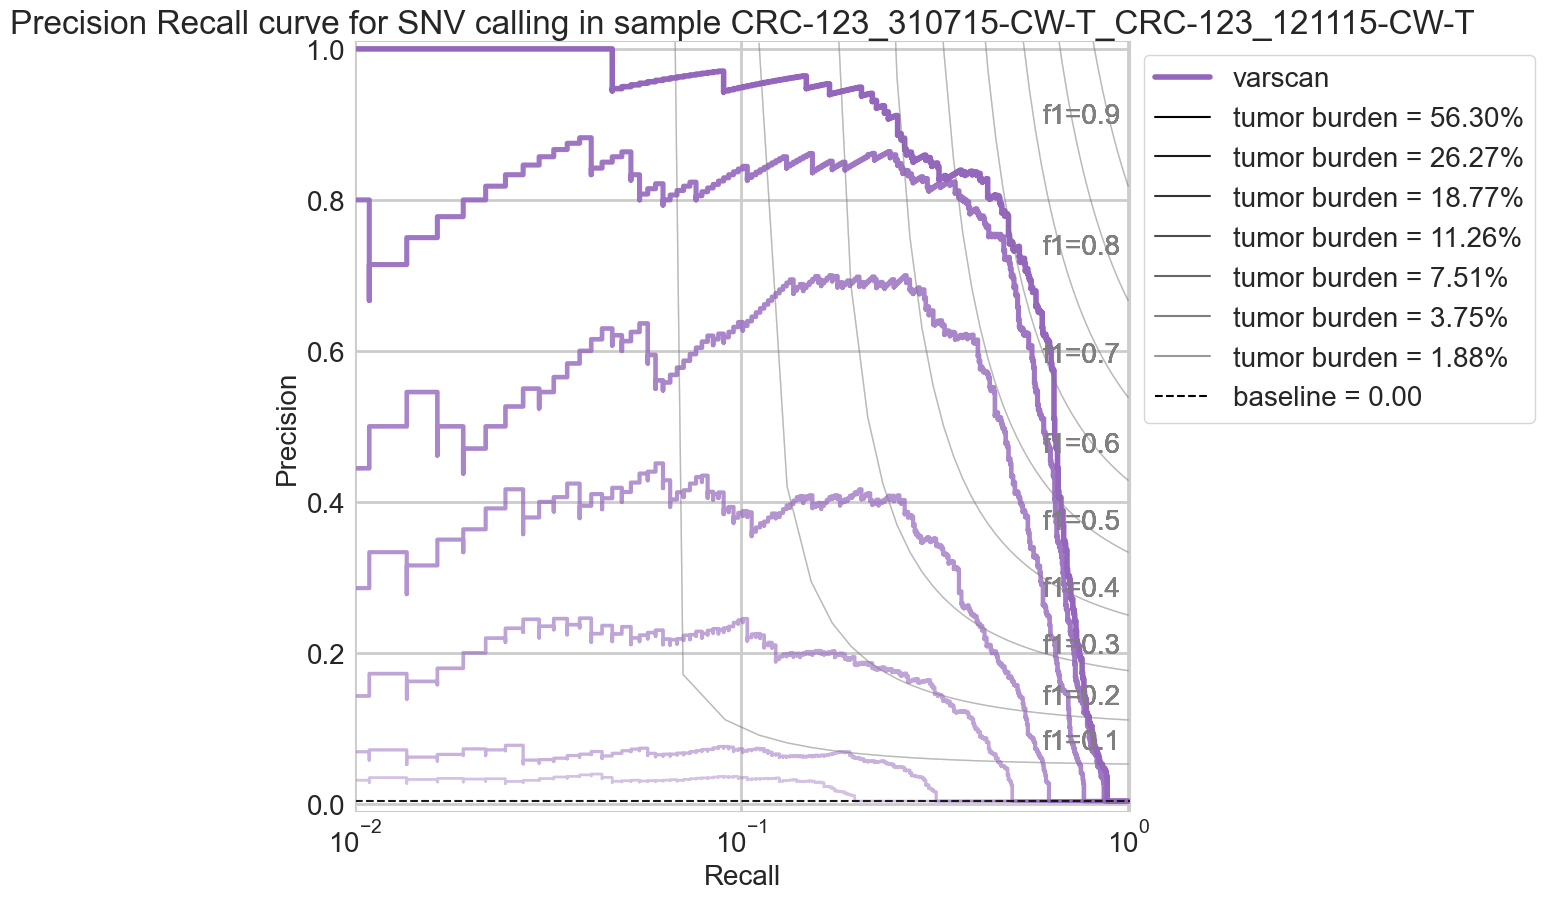

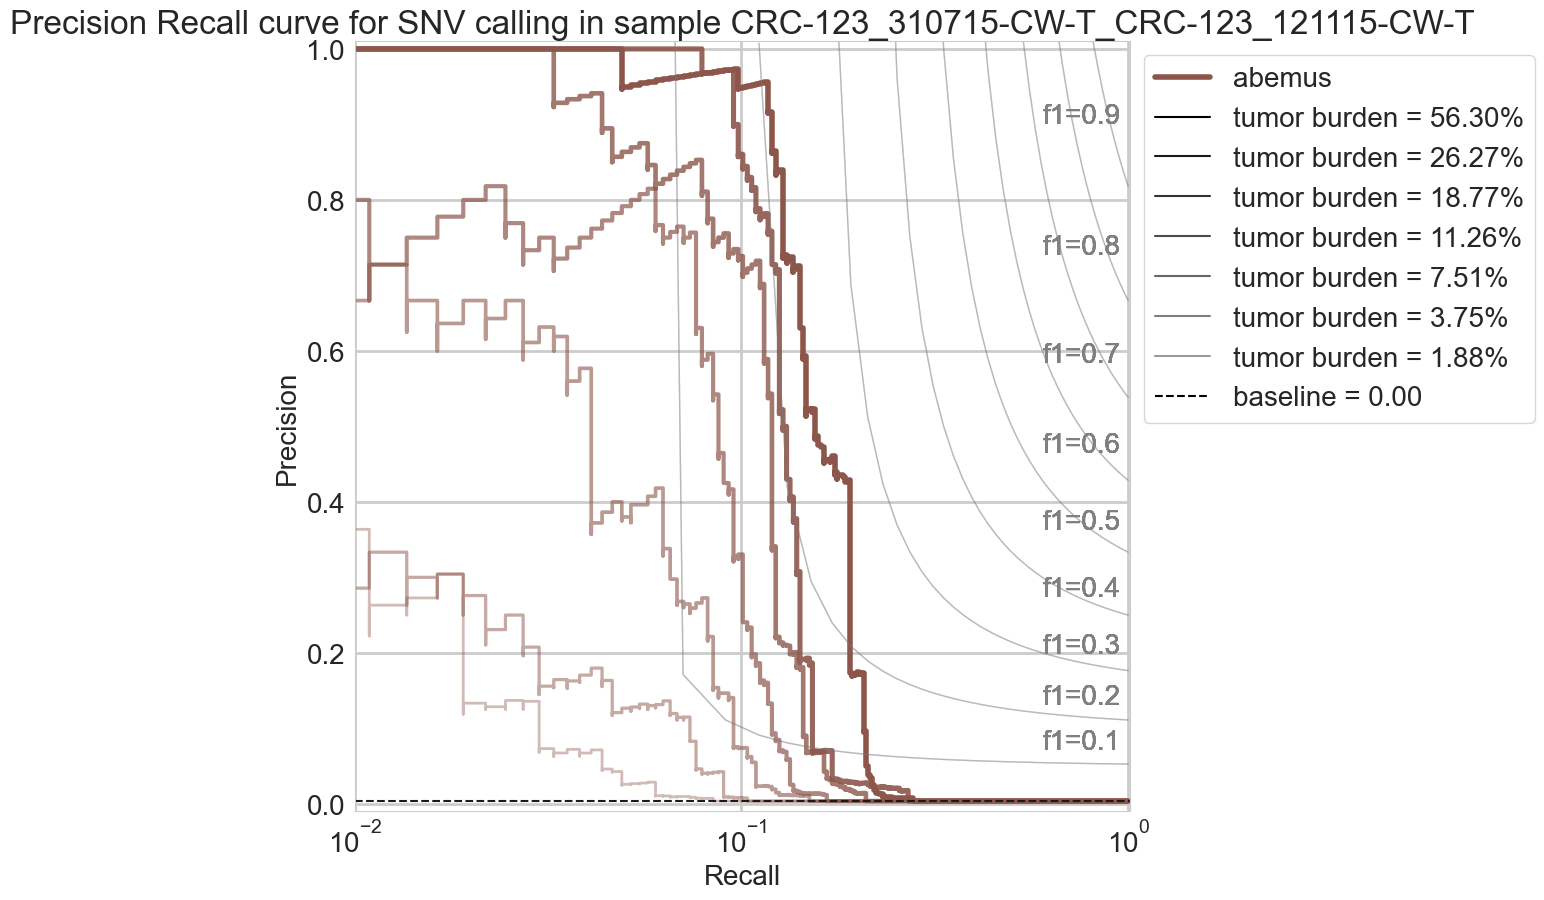

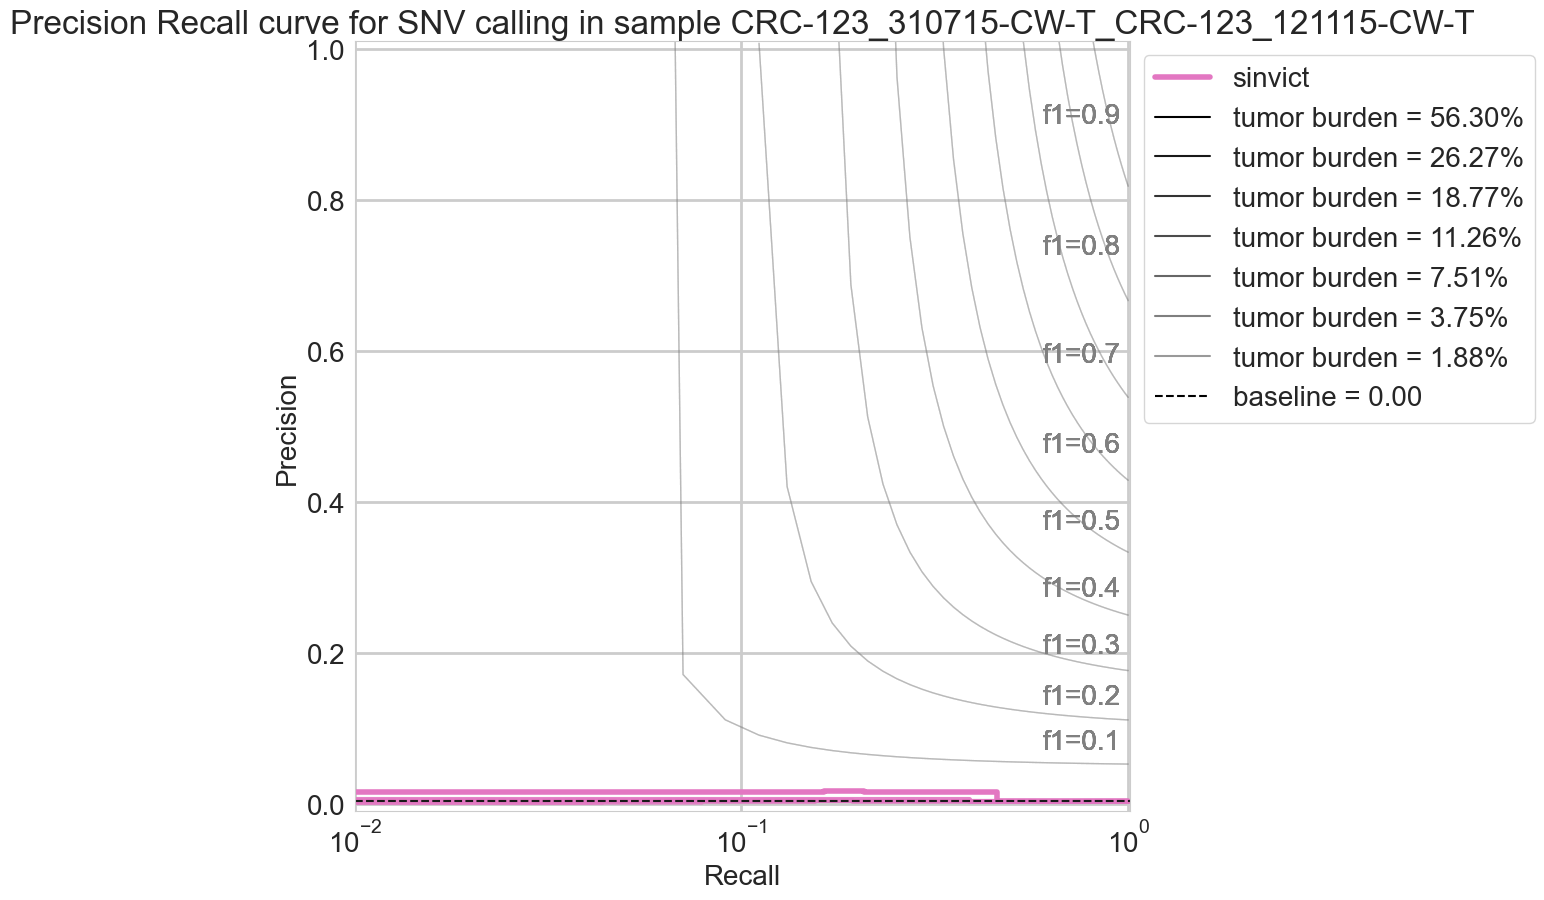

In [35]:
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
             refsample='undiluted', muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=False)

inundilutedsamplebyatleast4callers
CRC-1014_180816-CW-T_CRC-1014_090516-CW-T CRC-1014_180816-CW-T
tb
CRC-986_100215-CW-T_CRC-986_300316-CW-T CRC-986_100215-CW-T
tb
CRC-123_310715-CW-T_CRC-123_121115-CW-T CRC-123_310715-CW-T
tb
tumor burden
CRC-1014_180816-CW-T
CRC-986_100215-CW-T
CRC-123_310715-CW-T


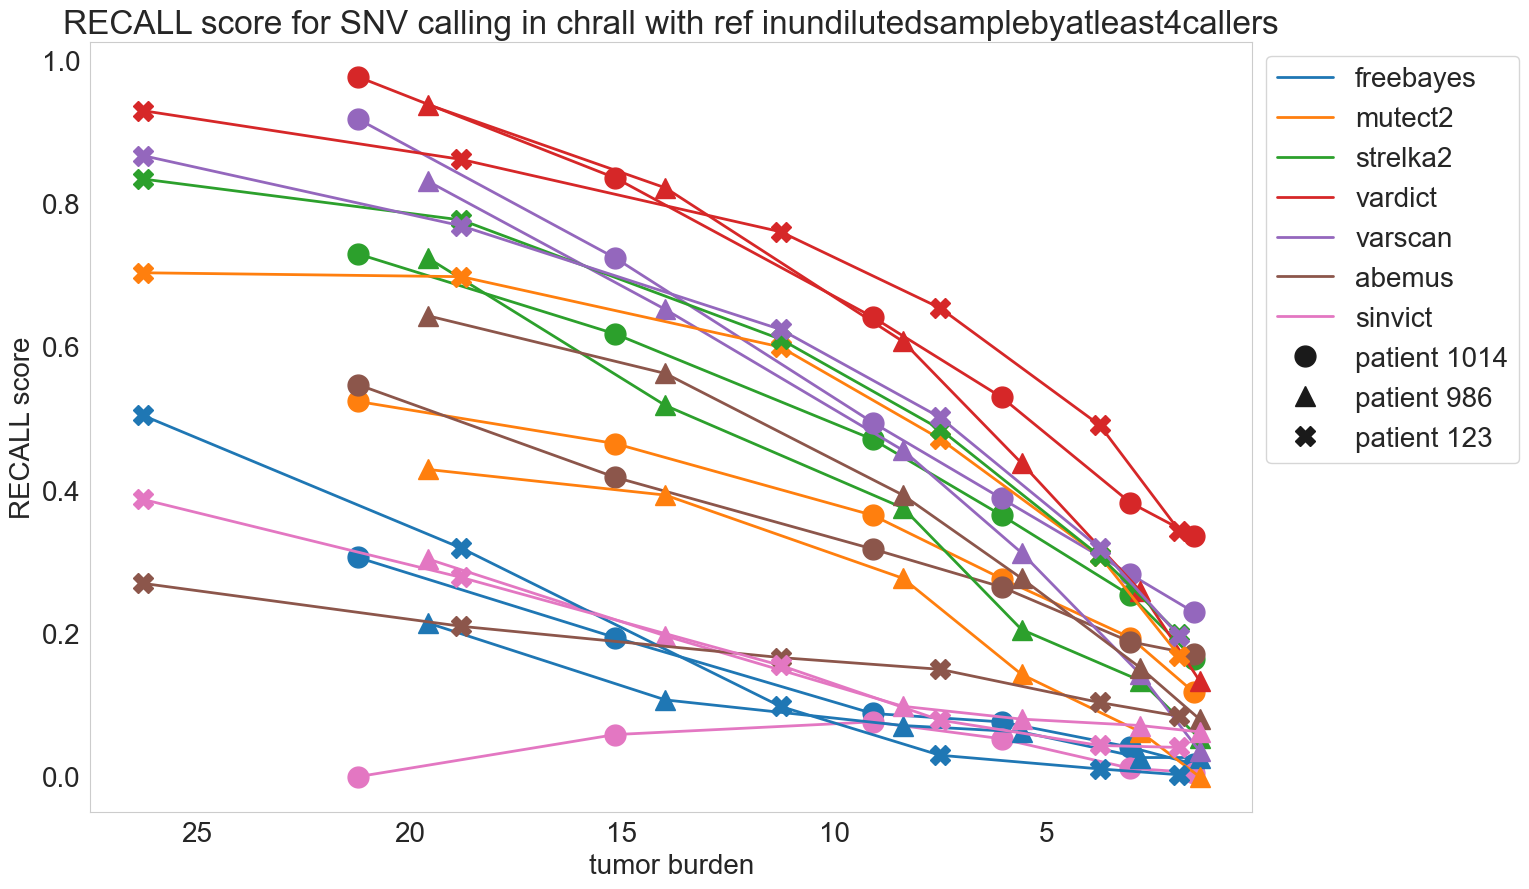

In [43]:
#plt.grid(linewidth=1)

#for fixedvar in fixedvars:
fixedvar = 'coverage'
if fixedvar == 'coverage':
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    xaxis = 'coverage'
#for mt in muttypes:
mt = 'snv'
if mt == 'snv':
    gtm = 4
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
else:  # elif mt == 'indel':
    gtm = 2
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
print(refname)
# for metric in metrics:
metric = 'recall'
# load results tables
restables = {'snv': [], 'indel': []}
for mixtureid in mixtureids:
    plasmasample = '_'.join(mixtureid.split('_')[:2])
    print(mixtureid, plasmasample)
    xa = xaxis if xaxis != 'tumor burden' else 'tb'
    print(xa)
    restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_allchr', 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar+'_'+ xa +'.csv'), index_col=0)
    #restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_chr22_wgs', 'mixtures_chr22_'+mixtureid, 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar +'.csv'), index_col=0)
    restable['plasma sample'] = plasmasample
    restables[mt].append(restable)
restables[mt] = pd.concat(restables[mt])
res1 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=False, save=False)
#res2 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=True, save=True)
#res3 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=False, save=True)
#res4 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                       ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=True, save=True)

In [44]:
resx = np.array([rx.values for rx in res1['x']])
resx.mean(axis=0)
resy = np.array([ry.values for ry in res1['y']])
res = {m: [] for m in config.methods}
for mi, m in enumerate(config.methods):
    resmean = np.mean([resy[mi], resy[mi+7], resy[mi+14]], axis=0)
    resstd = np.std([resy[mi], resy[mi+7], resy[mi+14]], axis=0)
    #reslabel = m
    res[m] = [resmean, resstd, resx.mean(axis=0)]

Text(0.5, 1.0, 'RECALL score for SNV calling in chrall with ref inundilutedsamplebyatleast4callers')

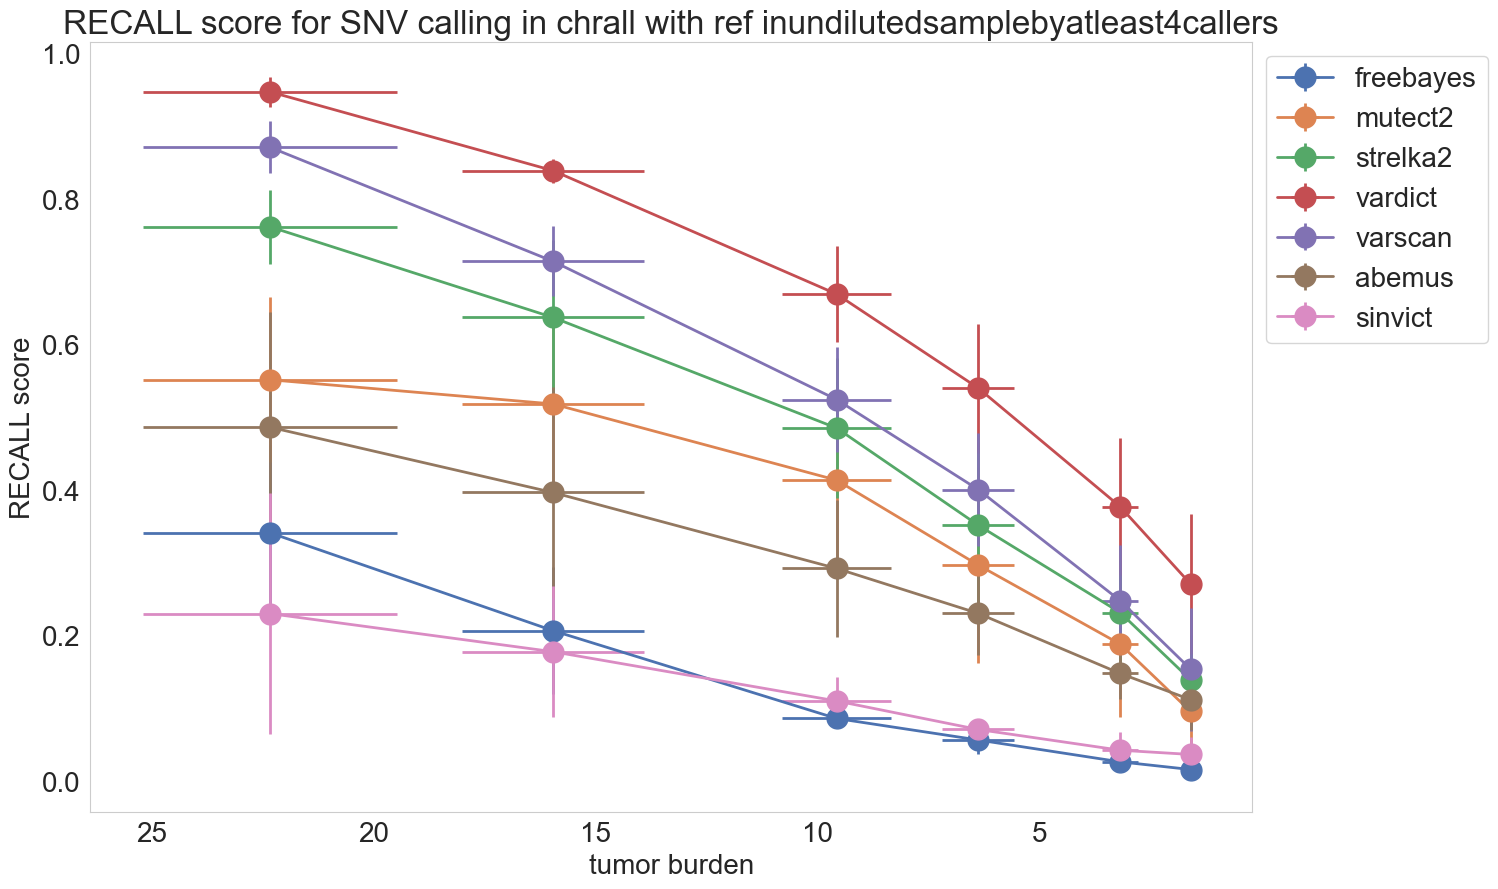

In [45]:
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(15, 10))
plt.grid(linewidth=1)
for m in config.methods:
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0), yerr=res[m][1], marker=config.markers[0], label=m,  markersize=15, lw=2, fmt='-o')
    plt.gca().invert_xaxis()
ax = plt.gca()
xlab = 'coverage or added noise'
xlab='tumor burden'
hand, labl = ax.get_legend_handles_labels()
ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel(xlab)
plt.ylabel(metric.upper()+' score')
plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))

In [ ]:
for m in config.methods:
    res[m][2] = res[m][2][::-1]
    res[m][0] = res[m][0][::-1]
    res[m][1] = res[m][1][::-1]

In [ ]:
#color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
#plt.figure(figsize=(15, 10))
#plt.grid(linewidth=1)
#res[m][2] = res[m][2][::-1]
#res[m][0] = res[m][0][::-1]
#res[m][1] = res[m][1][::-1]
rankres = []
for m in config.methods:
    xstart = 0
    ystart = 0
    sum_all = []
    for i in range(len(res[m][2])):
        #if i >0:
        #print(res[m][2][i], xstart)
        #print((res[m][2][i]-xstart) * res[m][0][i] )
        #print(((res[m][2][i]-xstart) * (res[m][0][i]-ystart)/2))
        sum_all.append(((res[m][2][i]-xstart) * res[m][0][i]) - ((res[m][2][i]-xstart) * (res[m][0][i]-ystart)/2))
        xstart = res[m][2][i]
        ystart = res[m][0][i]
    print(m, np.sum(sum_all) )
    rankres.append(np.sum(sum_all))
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    #plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0), yerr=res[m][1], marker=config.markers[0], label=m,  markersize=15, lw=2, fmt='-o')
    #plt.gca().invert_xaxis()
#ax = plt.gca()
#xlab = 'coverage or added noise'
#xlab='tumor burden'
#hand, labl = ax.get_legend_handles_labels()
#ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
#plt.xlabel(xlab)
#plt.ylabel(metric.upper()+' score')
#plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))

In [ ]:
import matplotlib.patches as mpatches
rankres_sort = np.argsort(rankres)[::-1]
rankres_sort
plt.figure(figsize=(14, 5))
method_order =[]
rank_order =[]
for i in rankres_sort:
    method_order.append(config.methods[i])
    rank_order.append(rankres[i])
plt.bar(method_order, rank_order, color=['b', 'b', 'b', 'b', 'b', 'r', 'r'])
blue_patch = mpatches.Patch(color='b', label='DNA methods')
red_patch = mpatches.Patch(color='r', label='cfDNA methods')
plt.legend(handles=[blue_patch, red_patch])
#plt.legend(['DNA methods', 'cfDNA methods'])
plt.ylabel('area under AUPRC curve')
plt.title('Caller ranking mixtures with decreasing tumor burden')